In [1]:
import numpy as np
import random 
from datetime import datetime
from numpy import genfromtxt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import os
from tqdm import *
from skimage.io import imread
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skimage import color

## Select S&P500 (Symbol = SPX) Dataset from 4 Jan 1960 to 31 Dec 2020

In [2]:
price_1=pd.read_csv('HistoricalPrices1.csv')
price_2=pd.read_csv('HistoricalPrices2.csv')
price_3=pd.read_csv('HistoricalPrices3.csv')
# remove redundant variables
price_3 = price_3.drop(['Volume', 'Adj Close' ], 1)
# transform Date to date timestamp
price_3['Date'] = pd.to_datetime(price_3['Date'])
price_3 = price_3.loc[ (price_3['Date'] < '1978-01-03') &  (price_3['Date']  >= '1960-01-01' )]
price_2['Date'] = pd.to_datetime(price_2['Date'])
price_1['Date'] = pd.to_datetime(price_1['Date'])
# reverse the dataset
price_2 = price_2.iloc[::-1].reset_index(drop = True)
price_1 = price_1.iloc[::-1].reset_index(drop = True)
# reset the column names
price_2.columns = ['Date', 'Open', 'High', 'Low', 'Close']
price_1.columns = ['Date', 'Open', 'High', 'Low', 'Close']
# combine three s&p500 datasets
# now the dataset includes all the s&p 500 price data from 4 Jan 1960 to 31 Dec 2020 
frames = [price_3, price_2, price_1]
price = pd.concat(frames).reset_index(drop = True)

# combine Schiller PE ratio
# the P/E ratio is monthly data 
pe = pd.read_csv('Schiller_PE_ratio.csv')
pe = pe.rename({'Date':'Date_PE'},axis=1)
price['Date_PE']=0.0
for i in range(price.shape[0]):
    month = price['Date'][i].month
    year = price['Date'][i].year
    price.loc[i, 'Date_PE']=year+month*0.01
# merge sp500 data with the Schiller P/E ratio based on Date.
data_full = pd.merge(price, pe, how='left', on='Date_PE')
data_full = data_full.drop(['Date_PE' ], 1)
data_full

/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_40997/308392918.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price_3 = price_3.drop(['Volume', 'Adj Close' ], 1)
/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_40997/308392918.py:33: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_full = data_full.drop(['Date_PE' ], 1)


,Date,Open,High,Low,Close,PE_CAPE
0,1960-01-04,59.910000,59.910000,59.910000,59.910000,18.338285
1,1960-01-05,60.389999,60.389999,60.389999,60.389999,18.338285
2,1960-01-06,60.130001,60.130001,60.130001,60.130001,18.338285
3,1960-01-07,59.689999,59.689999,59.689999,59.689999,18.338285
4,1960-01-08,59.500000,59.500000,59.500000,59.500000,18.338285
...,...,...,...,...,...,...
15349,2020-12-24,3694.030000,3703.820000,3689.320000,3703.060000,33.769789
15350,2020-12-28,3723.030000,3740.510000,3723.030000,3735.360000,33.769789
15351,2020-12-29,3750.010000,3756.120000,3723.310000,3727.040000,33.769789
15352,2020-12-30,3736.190000,3744.630000,3730.210000,3732.040000,33.769789


## Develop and test/verify a correlation-based algorithm to correlate when the Schiller P/E ratio is very high (spikes upward significantly) and the S&P500 is also high (peaking or ready to peak).

### Make an overlay of the Schiller P/E ration onto the S&P 500 data.

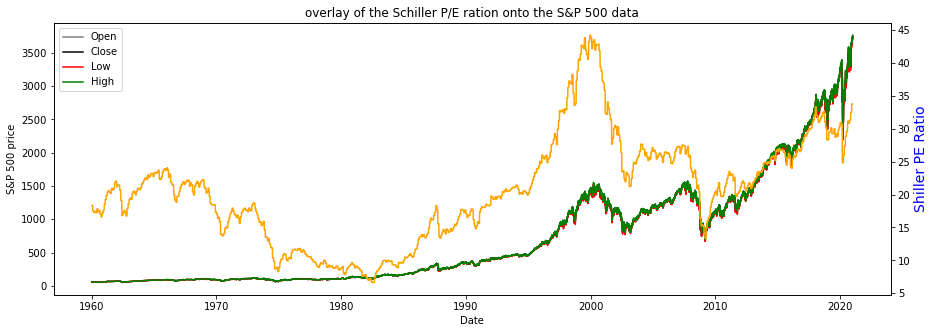

In [3]:
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date, data_full.Open.values, color='grey', label='Open')
plt.plot(data_full.Date, data_full.Close.values, color='black', label='Close')
plt.plot(data_full.Date, data_full.Low.values, color='red', label='Low')
plt.plot(data_full.Date, data_full.High.values, color='green', label='High')
plt.title('overlay of the Schiller P/E ration onto the S&P 500 data')
plt.xlabel('Date')
plt.ylabel('S&P 500 price')
plt.legend(loc='best')
# twin object for two different y-axis on the sample plot
ax2=plt.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data_full.Date, data_full.PE_CAPE.values,color="orange")
ax2.set_ylabel("Shiller PE Ratio", color="blue",fontsize=14)
plt.show()

### Data scale

In [4]:
# construct dataset contains the S&P 500 price and the Schiller P/E ratio(implement close and Schiller PE ratio)
dataset = data_full[['Close', 'PE_CAPE']].values
# construct date_data to extract the timestamp data
date_data= data_full[ ['Date']].values
# due to the value of the data set is too small, avoiding out of range, we need to scale data.
# implement min-max normalization to the features.
scaler = MinMaxScaler(feature_range = (0, 1))
dataset_scaled = scaler.fit_transform(dataset)
dataset_scaled

array([[0.00208161, 0.31149771],
       [0.0022112 , 0.31149771],
       [0.002141  , 0.31149771],
       ...,
       [0.99216225, 0.72235494],
       [0.99351219, 0.72235494],
       [1.        , 0.72235494]])

### Calculate correlation score S by implementing Pearson correlation coefficient and add it to the dataset and dataset_scaled.

In [5]:
# initialize S with 0
dataset = np.append(dataset, np.zeros([len(dataset),1]),1)
dataset_scaled = np.append(dataset_scaled, np.zeros([len(dataset_scaled),1]),1)
# window size is 180
nsample = 180
# implement pearson correlation coefficient to calculate the correlation between the S&P 500 price and the Schiller P/E ratio
for i in range(nsample-1, len(dataset)):
    x = dataset[(i-nsample+1):(i+1), 0]
    y = dataset[(i-nsample+1):(i+1), 1]
    r = np.corrcoef(x, y)
    dataset[i][2] = r[0,1]
    dataset_scaled[i][2] = r[0,1]
print(dataset)
print(dataset_scaled)

[[5.99100000e+01 1.83382850e+01 0.00000000e+00]
 [6.03899990e+01 1.83382850e+01 0.00000000e+00]
 [6.01300010e+01 1.83382850e+01 0.00000000e+00]
 ...
 [3.72704000e+03 3.37697894e+01 9.66362673e-01]
 [3.73204000e+03 3.37697894e+01 9.66086163e-01]
 [3.75607000e+03 3.37697894e+01 9.65798692e-01]]
[[0.00208161 0.31149771 0.        ]
 [0.0022112  0.31149771 0.        ]
 [0.002141   0.31149771 0.        ]
 ...
 [0.99216225 0.72235494 0.96636267]
 [0.99351219 0.72235494 0.96608616]
 [1.         0.72235494 0.96579869]]


Text(0, 0.5, 'Pearson Correlation')

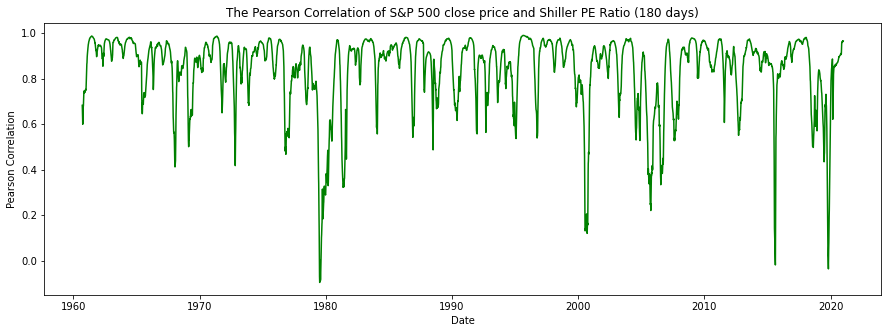

In [6]:
# show the correlation between the S&P 500 price and the Schiller P/E ratio
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date.loc[~data_full.Date.index.isin(list(range(nsample-1))) ],
         dataset[(nsample-1):, 2], color='green', label='Close')
plt.title('The Pearson Correlation of S&P 500 close price and Shiller PE Ratio (180 days)')
plt.xlabel('Date')
plt.ylabel('Pearson Correlation')

### When the correlation is greater than 0.97, sell the S&P 500 index. When it achieves the local minima, buy in the S&P 500. Sell all at the end point.

In [7]:
# assuming we have $1 million at the beginning
money = 1
money_end = []
trade_end = []
# we can not buy a new one until we sell the stock
last_trade = 0
for i in range(nsample-1, dataset.shape[0]):
    correlation_temp = dataset[i,2]
    price_temp = dataset[(i-nsample+1):(i+1), 0]
    if correlation_temp > 0.97 and (i-last_trade > nsample):
        # sell the stock
        # re-buy at the local minimum in the next 180 days
        buy_price = min(price_temp)
        if buy_price > 0:
            sell_price = price_temp[len(price_temp)-1]
            money = sell_price/buy_price * money
            last_trade = i
            money_end.append(money)
            trade_end.append(i)
print('The final money is: ', money)

The final money is:  240.6774647362213


Text(0, 0.5, 'Money (millions)')

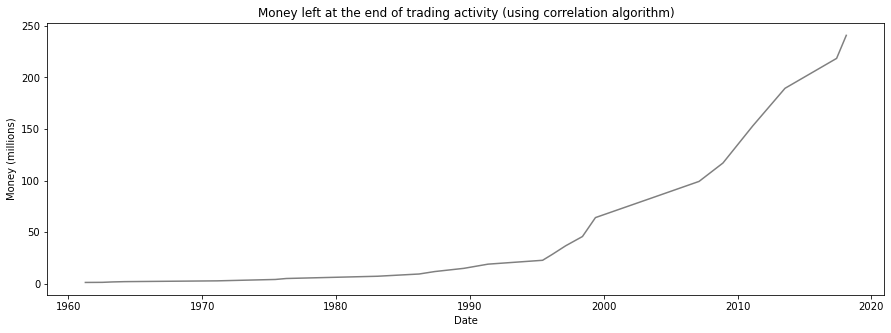

In [8]:
# show the trends of the money left
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date.loc[trade_end],
         money_end, color='grey', label='Close')
plt.title('Money left at the end of trading activity (using correlation algorithm)')
plt.xlabel('Date')
plt.ylabel('Money (millions)')

## Design and develop a convolutional neural network (CNN) in Python that will recognize A-B-C-D-wave patterns in the S&P500 data, using libraries such as PyTorch.

### Create a function to plot data and save plot into a folder.

In [9]:
# function to plot the sp500 price data and save the plot
def drawPlotAndSave(data,index,folder):
    closedpriceInPreventDays = []
    xaxis = np.arange(0, nsample)
    for x in reversed(range(0, nsample)):
        closedpriceInPreventDays.append(data[index-x][0])        
    # plot the sp500 price data
    name = "day%i" %index
    plt.axis('off')
    plt.plot(closedpriceInPreventDays, color ="blue") 
    name = name + '.png'
    figure = plt.gcf()
    figure.set_size_inches(6, 6)
    # create a folder and then save the plot
    plt.savefig(folder + name, bbox_inches='tight', pad_inches=0, dpi = 100)
    plt.clf()    

### Find some representative figures which include A-B-C-D-wave patterns. We pick data where the correlation coefficient of S&P500 and Schiller P/E ratio is larger than 0.97. The end price is the highest and the S&P 500 price will drop after that day.

In [10]:
# the index of the dataset_scaled for sell signal
sellSignalIndex = []
prevent = 0
for i in range (nsample-1,len(dataset_scaled)):
    if (dataset_scaled[i][2] > 0.97) and \
        (i >= prevent+nsample//3) and \
        (dataset_scaled[i][0] == max(dataset_scaled[(i-nsample+1):(i+1),0])) and \
        (dataset_scaled[i][0] > dataset_scaled[i+1,0]):
        sellSignalIndex.append(i)
        prevent = i
# create a folder to save the plot
folder = 'ReadyToSell_Train/'
if not os.path.exists(folder):
    os.makedirs(folder)
# save sell signal pictures into the folder
for i in range(0, len(sellSignalIndex)):
    drawPlotAndSave(dataset_scaled, sellSignalIndex[i], folder)

<Figure size 432x432 with 0 Axes>

### Find some representative figures which doesn't include A-B-C-D-wave patterns. We pick data where the correlation coefficient of S&P500 and Schiller P/E ratio is less than 0.6. The end price isn't the highest.

In [11]:
# the index of the dataset_scaled for hold signal
holdSignalIndex = []
prevent = 0
for i in range (nsample-1,len(dataset_scaled)):
    if (dataset_scaled[i][2] < 0.6) and \
        (i >= prevent+nsample//3) and \
        (dataset_scaled[i][0] < max(dataset_scaled[(i-nsample+1):(i+1),0])):
        holdSignalIndex.append(i)
        prevent = i
# create a folder to save the plot
folder = 'ReadyToHold_Train/'
if not os.path.exists(folder):
    os.makedirs(folder)
# save hold signal pictures into the folder
for i in range(0, len(holdSignalIndex)):
    drawPlotAndSave(dataset_scaled, holdSignalIndex[i], folder)

<Figure size 432x432 with 0 Axes>

### Picking Training samples which fit the A-B-C-D-wave pattern.

In [12]:
# training images
train_img = []
# implement tqdm to show the progress of the training
# pick data from sell signal pictures
for name_img in tqdm(sellSignalIndex):
    # image path
    path = 'ReadyToSell_Train/day' + str(name_img) + '.png'
    # read the image
    img = imread(path,as_gray=True)
    # resize the image
    img = resize(img, (200, 200),anti_aliasing=True)
    # convert the pixel value to float 32
    img = img.astype('float32')
    # append the image into the train_img
    train_img.append(img)
train_y = np.repeat(1, len(sellSignalIndex))
# pick data from hold signal pictures
for name_img in tqdm(holdSignalIndex):
    # image path
    path = 'ReadyToHold_Train/day' + str(name_img) + '.png'
    # read the image
    img = imread(path,as_gray=True)
    # resize the image
    img = resize(img, (200, 200),anti_aliasing=True)
    # convert the pixel value to float 32
    img = img.astype('float32')
    # append the image into the train_img
    train_img.append(img)
train_y = np.append(train_y, np.repeat(0, len(holdSignalIndex)))
# transfer the list into numpy array
train_x = np.array(train_img)
train_x.shape

100%|██████████| 37/37 [00:00<00:00, 63.41it/s]


(60, 200, 200)

### Plot some samples from sell dataset and hold dataset images.

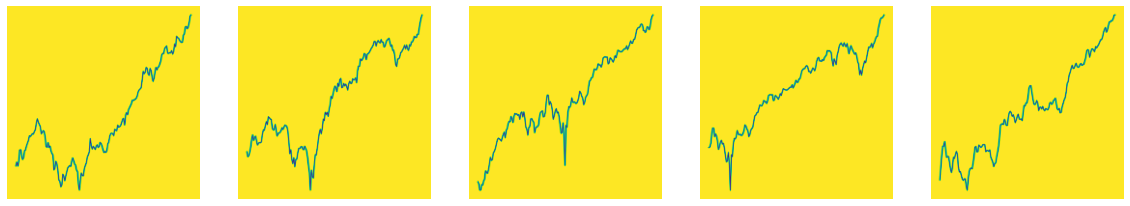

In [13]:
# display first 5 images in the sell dataset
fig, axs = plt.subplots(1, 5 ,figsize=(20,20))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(train_x[i], vmin=0, vmax=1)
    ax.axis('off')
plt.show()

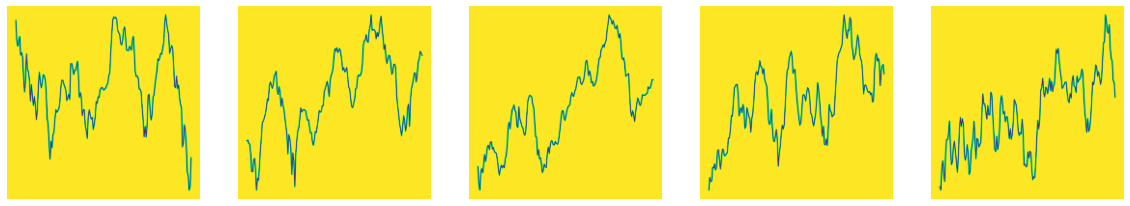

In [14]:
# display first 5 images in the hold dataset
fig, axs = plt.subplots(1, 5 ,figsize=(20,20))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(train_x[len(sellSignalIndex)+ i], vmin=0, vmax=1)
    ax.axis('off')
plt.show()

### Construct the training set and testing set.

In [15]:
# transfer training data into torch tensor
train_x = train_x.reshape(train_x.shape[0],1,train_x.shape[1],train_x.shape[2])
train_x = torch.from_numpy(train_x)
# transfer target data into torch tensor
train_y = train_y.astype(int)
train_y = torch.from_numpy(train_y)
print(train_x.shape)
print(train_y.shape)

torch.Size([60, 1, 200, 200])
torch.Size([60])


### Construct the CNN network.

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn_layers = nn.Sequential(
            # define a 2D convolution layer
            nn.Conv2d(1,4,kernel_size=3,stride=1,padding=1),
            # define a batch normalization layer
            nn.BatchNorm2d(4),
            # define a relu activation function
            nn.ReLU(inplace=True),
            # define a max pooling layer
            nn.MaxPool2d(kernel_size=2,stride=2),
            # define an additional 2D convolution layer
            nn.Conv2d(4,4,kernel_size=3,stride=1,padding=1),
            # define a batch normalization layer
            nn.BatchNorm2d(4),
            # define a relu activation function
            nn.ReLU(inplace=True),
            # define a max pooling layer
            nn.MaxPool2d(kernel_size=2,stride=2),
        )
        self.fc_layers = nn.Sequential(
            # define a fully connected layer
            nn.Linear(10000,2)
        )

    # define the forward pass
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


In [17]:
# define the CNN model
model = CNN()
# define the loss function
criterion = nn.CrossEntropyLoss()
# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

CNN(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=10000, out_features=2, bias=True)
  )
)


### Construct the training function for CNN model.

In [18]:
def train(epoch):
    model.train()
    # define the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # clear the gradient
    optimizer.zero_grad()
    # get prediction for training set
    output_train = model(x_train)
    # calculate the loss
    loss_train = criterion(output_train, y_train)
    train_losses.append(loss_train)
    # backpropagation
    loss_train.backward()
    # update the parameters
    optimizer.step()
    # print the training loss
    if epoch % 5 == 0:
        print('Epoch: ', epoch+1,  '| Loss: %.2f' %(loss_train.detach().numpy()))


    # get the prediction for training set
    with torch.no_grad():
        output_temp = model(train_x)
    
    softmax = torch.exp(output_temp)
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)

    # calculate the training set accuracy
    train_accuracy.append(accuracy_score(train_y, predictions))

    # get the accuracy for holding and selling data
    countHold = sum(np.logical_and(predictions == 0, train_y.numpy() == 0))
    countSell = sum(np.logical_and(predictions == 1, train_y.numpy() == 1))
    
    accuracyHold = countHold/sum(train_y == 0)
    accuracySell = countSell/sum(train_y == 1)
    if epoch%5 == 0:
        print('Epoch: ', epoch+1,  '| Sell/Hold accuracy: %.2f/%.2f' %(accuracySell, accuracyHold))
        print('Epoch: ', epoch+1,  '| TrainAccuracy: %.2f' %(train_accuracy[-1]))

### Find the best epoch.

#### 10 epoch

In [19]:
# defining the number of epochs
n_epochs = 10
# storing the training loss
train_losses = []
# storing the training set accuracy
train_accuracy = []
# training the model
print("Number of train samples: ", len(train_y))
for epoch in range(n_epochs):
    train(epoch)

Number of train samples:  60
Epoch:  1 | Loss: 0.58
Epoch:  1 | Sell/Hold accuracy: 0.65/1.00
Epoch:  1 | TrainAccuracy: 0.87
Epoch:  6 | Loss: 0.42
Epoch:  6 | Sell/Hold accuracy: 0.65/1.00
Epoch:  6 | TrainAccuracy: 0.87


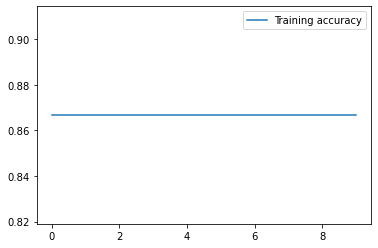

In [20]:
# plotting the training accuracy
plt.plot(train_accuracy, label='Training accuracy')
plt.legend()
plt.show()

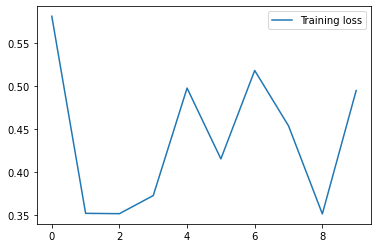

In [21]:
# transfer tensor to numpy array
for i in range(len(train_losses)):
    train_losses[i] = train_losses[i].detach().numpy()
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.legend()
plt.show()

#### 20 epoch

In [22]:
# define the CNN model
model = CNN()
# define the loss function
criterion = nn.CrossEntropyLoss()
# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

CNN(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=10000, out_features=2, bias=True)
  )
)


In [23]:
# defining the number of epochs
n_epochs = 20
# storing the training loss
train_losses = []
# storing the training set accuracy
train_accuracy = []
# training the model
print("Number of train samples: ", len(train_y))
for epoch in range(n_epochs):
    train(epoch)

Number of train samples:  60
Epoch:  1 | Loss: 0.55
Epoch:  1 | Sell/Hold accuracy: 0.65/1.00
Epoch:  1 | TrainAccuracy: 0.87
Epoch:  6 | Loss: 0.80
Epoch:  6 | Sell/Hold accuracy: 0.65/1.00
Epoch:  6 | TrainAccuracy: 0.87
Epoch:  11 | Loss: 0.45
Epoch:  11 | Sell/Hold accuracy: 0.65/1.00
Epoch:  11 | TrainAccuracy: 0.87
Epoch:  16 | Loss: 0.40
Epoch:  16 | Sell/Hold accuracy: 0.65/1.00
Epoch:  16 | TrainAccuracy: 0.87


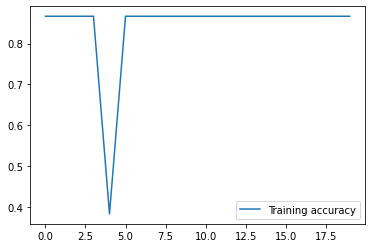

In [24]:
# plotting the training accuracy
plt.plot(train_accuracy, label='Training accuracy')
plt.legend()
plt.show()

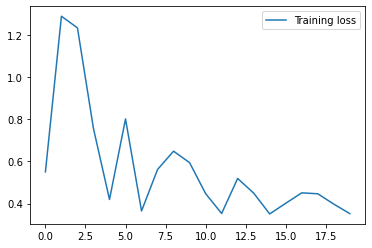

In [25]:
# transfer tensor to numpy array
for i in range(len(train_losses)):
    train_losses[i] = train_losses[i].detach().numpy()
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.legend()
plt.show()

#### 30 epoch

In [26]:
# define the CNN model
model = CNN()
# define the loss function
criterion = nn.CrossEntropyLoss()
# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

CNN(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=10000, out_features=2, bias=True)
  )
)


In [27]:
# defining the number of epochs
n_epochs = 30
# storing the training loss
train_losses = []
# storing the training set accuracy
train_accuracy = []
# training the model
print("Number of train samples: ", len(train_y))
for epoch in range(n_epochs):
    train(epoch)

Number of train samples:  60
Epoch:  1 | Loss: 0.69
Epoch:  1 | Sell/Hold accuracy: 0.65/1.00
Epoch:  1 | TrainAccuracy: 0.87
Epoch:  6 | Loss: 0.42
Epoch:  6 | Sell/Hold accuracy: 0.65/1.00
Epoch:  6 | TrainAccuracy: 0.87
Epoch:  11 | Loss: 0.54
Epoch:  11 | Sell/Hold accuracy: 0.65/1.00
Epoch:  11 | TrainAccuracy: 0.87
Epoch:  16 | Loss: 0.42
Epoch:  16 | Sell/Hold accuracy: 0.65/1.00
Epoch:  16 | TrainAccuracy: 0.87
Epoch:  21 | Loss: 0.40
Epoch:  21 | Sell/Hold accuracy: 0.65/1.00
Epoch:  21 | TrainAccuracy: 0.87
Epoch:  26 | Loss: 0.35
Epoch:  26 | Sell/Hold accuracy: 0.65/1.00
Epoch:  26 | TrainAccuracy: 0.87


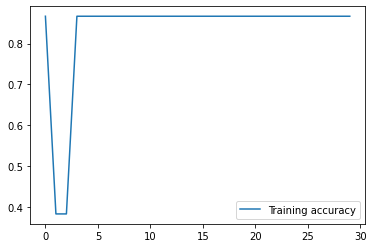

In [28]:
# plotting the training accuracy
plt.plot(train_accuracy, label='Training accuracy')
plt.legend()
plt.show()

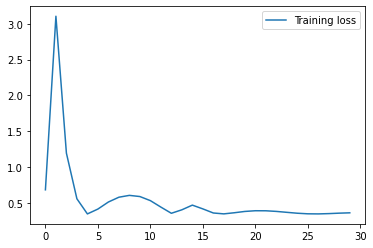

In [29]:
# transfer tensor to numpy array
for i in range(len(train_losses)):
    train_losses[i] = train_losses[i].detach().numpy()
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.legend()
plt.show()

#### 40 epoch

In [30]:
# define the CNN model
model = CNN()
# define the loss function
criterion = nn.CrossEntropyLoss()
# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

CNN(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=10000, out_features=2, bias=True)
  )
)


In [31]:
# defining the number of epochs
n_epochs = 40
# storing the training loss
train_losses = []
# storing the training set accuracy
train_accuracy = []
# training the model
print("Number of train samples: ", len(train_y))
for epoch in range(n_epochs):
    train(epoch)

Number of train samples:  60
Epoch:  1 | Loss: 0.80
Epoch:  1 | Sell/Hold accuracy: 0.65/1.00
Epoch:  1 | TrainAccuracy: 0.87
Epoch:  6 | Loss: 0.37
Epoch:  6 | Sell/Hold accuracy: 0.65/1.00
Epoch:  6 | TrainAccuracy: 0.87
Epoch:  11 | Loss: 0.35
Epoch:  11 | Sell/Hold accuracy: 0.65/1.00
Epoch:  11 | TrainAccuracy: 0.87
Epoch:  16 | Loss: 0.36
Epoch:  16 | Sell/Hold accuracy: 0.65/1.00
Epoch:  16 | TrainAccuracy: 0.87
Epoch:  21 | Loss: 0.36
Epoch:  21 | Sell/Hold accuracy: 0.65/1.00
Epoch:  21 | TrainAccuracy: 0.87
Epoch:  26 | Loss: 0.36
Epoch:  26 | Sell/Hold accuracy: 0.65/1.00
Epoch:  26 | TrainAccuracy: 0.87
Epoch:  31 | Loss: 0.36
Epoch:  31 | Sell/Hold accuracy: 0.65/1.00
Epoch:  31 | TrainAccuracy: 0.87
Epoch:  36 | Loss: 0.36
Epoch:  36 | Sell/Hold accuracy: 0.65/1.00
Epoch:  36 | TrainAccuracy: 0.87


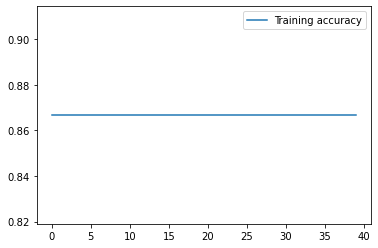

In [32]:
# plotting the training accuracy
plt.plot(train_accuracy, label='Training accuracy')
plt.legend()
plt.show()

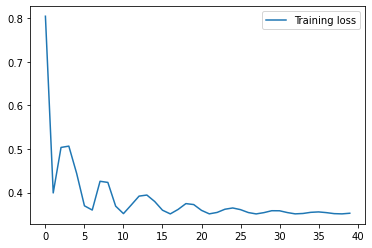

In [33]:
# transfer tensor to numpy array
for i in range(len(train_losses)):
    train_losses[i] = train_losses[i].detach().numpy()
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.legend()
plt.show()

#### 50 epoch

In [34]:
# define the CNN model
model = CNN()
# define the loss function
criterion = nn.CrossEntropyLoss()
# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

CNN(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=10000, out_features=2, bias=True)
  )
)


In [35]:
# defining the number of epochs
n_epochs = 50
# storing the training loss
train_losses = []
# storing the training set accuracy
train_accuracy = []
# training the model
print("Number of train samples: ", len(train_y))
for epoch in range(n_epochs):
    train(epoch)

Number of train samples:  60
Epoch:  1 | Loss: 0.69
Epoch:  1 | Sell/Hold accuracy: 0.65/1.00
Epoch:  1 | TrainAccuracy: 0.87
Epoch:  6 | Loss: 0.35
Epoch:  6 | Sell/Hold accuracy: 1.00/0.00
Epoch:  6 | TrainAccuracy: 0.38
Epoch:  11 | Loss: 0.43
Epoch:  11 | Sell/Hold accuracy: 0.65/1.00
Epoch:  11 | TrainAccuracy: 0.87
Epoch:  16 | Loss: 0.35
Epoch:  16 | Sell/Hold accuracy: 0.65/1.00
Epoch:  16 | TrainAccuracy: 0.87
Epoch:  21 | Loss: 0.35
Epoch:  21 | Sell/Hold accuracy: 0.65/1.00
Epoch:  21 | TrainAccuracy: 0.87
Epoch:  26 | Loss: 0.37
Epoch:  26 | Sell/Hold accuracy: 0.65/1.00
Epoch:  26 | TrainAccuracy: 0.87
Epoch:  31 | Loss: 0.36
Epoch:  31 | Sell/Hold accuracy: 0.65/1.00
Epoch:  31 | TrainAccuracy: 0.87
Epoch:  36 | Loss: 0.36
Epoch:  36 | Sell/Hold accuracy: 0.65/1.00
Epoch:  36 | TrainAccuracy: 0.87
Epoch:  41 | Loss: 0.36
Epoch:  41 | Sell/Hold accuracy: 0.65/1.00
Epoch:  41 | TrainAccuracy: 0.87
Epoch:  46 | Loss: 0.36
Epoch:  46 | Sell/Hold accuracy: 0.65/1.00
Epoch:  46

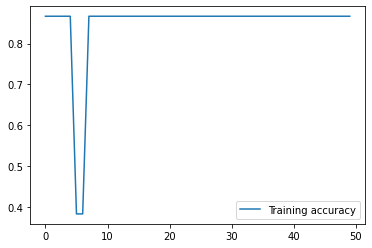

In [36]:
# plotting the training accuracy
plt.plot(train_accuracy, label='Training accuracy')
plt.legend()
plt.show()

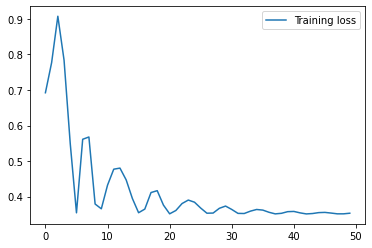

In [37]:
# transfer tensor to numpy array
for i in range(len(train_losses)):
    train_losses[i] = train_losses[i].detach().numpy()
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.legend()
plt.show()

## Train CNN and RNN on Training Set (S&P500 data and Schiller P/E data) then test to ensure it functions correctly when predicting the next one, two, three, and four trading data.

### Construct general settings for RNN network.

In [38]:
# the number of features for the input is 3
input_size = 3
# the number of outputs for the input is 4
output_size = 4
# sequence length is 180
window_size = 180
# number of time points and features
n_rows, n_cols = dataset_scaled.shape
# other settings for the RNN model
hidden_size = 16
num_layers = 1
num_epochs = 200
learning_rate = 0.001

### Construct data structure for CNN network usage.

In [39]:
x_full = []
y_full = []
date_full = []
for i in range (n_rows - window_size - output_size + 1):
    x_full.append(dataset_scaled[i:i+window_size,])
    y_full.append(dataset_scaled[i+window_size:i+window_size+output_size, 0])
    date_full.append(date_data[i+window_size])
x_full,y_full,date_full = np.array(x_full), np.array(y_full), np.array(date_full)
y_full = np.reshape(y_full, (y_full.shape[0], 1, y_full.shape[1]))

### Construct the RNN network.

In [40]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # define the RNN layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # define the fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    # define the forward pass
    def forward(self, x):
        # get the hidden state
        hidden = self.init_hidden(x.size(0))
        # put the input and hidden state through the RNN and get the output
        out, hidden = self.rnn(x, hidden)
        # resize the output in order to feed it to the fully connected layer
        out_resize = self.fc(out)
        # just need the last date of the output
        return out_resize [:, -1, :], hidden
    
    # initialize the hidden state
    def init_hidden(self, batch_size):
        # initialize the hidden state with zero tensor
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden

### Implementing CNN on all data, then adding the result of CNN into input dataset of RNN.

In [41]:
# construct image dataset from all dataset
img_all = []
for i in range(x_full.shape[0]):
    # close price
    x = x_full[i,:,0]
    # plot the S&P 500 close price data
    plt.axis('off')
    plt.plot(x, color ="blue", label = "Close Price")
    figure = plt.gcf()
    figure.set_size_inches(8, 8)
    figure.canvas.draw()
    width, height = figure.get_size_inches() * figure.get_dpi()
    mplimage = np.frombuffer(figure.canvas.tostring_rgb(), dtype='uint8').reshape(576, 576, 3)
    gray_image = color.rgb2gray(mplimage)
    img_resize = resize(gray_image, (200, 200),anti_aliasing=True)
    img_resize = img_resize.astype('float32')
    plt.clf()   
    # appending the image into the list
    img_all.append(img_resize)
# change the list into numpy array
x_all = np.array(img_all)
x_all.shape

(15171, 200, 200)

<Figure size 576x576 with 0 Axes>

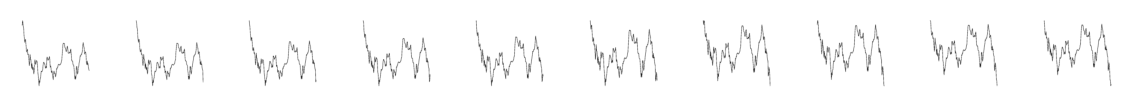

In [42]:
# display first 10 images 
fig, axs = plt.subplots(1, 10 ,figsize=(20,20))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(x_all[i], cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
plt.show()

#### At this time, we also implement the close price and the Schiller P/E ratio as the dataset. In order to avoid data redundant, we construct a new dataset which is different from the previous one.

In [43]:
# construct dataset with only close data and Schiller P/E ratio
dataset_part = data_full[ ['Close', 'PE_CAPE']].values
dataset_part = np.append(dataset_part, np.zeros([len(dataset_part),1]),1)
dataset_part.shape

(15354, 3)

In [44]:
dataset_part

array([[  59.91      ,   18.33828499,    0.        ],
       [  60.389999  ,   18.33828499,    0.        ],
       [  60.130001  ,   18.33828499,    0.        ],
       ...,
       [3727.04      ,   33.76978942,    0.        ],
       [3732.04      ,   33.76978942,    0.        ],
       [3756.07      ,   33.76978942,    0.        ]])

In [45]:
# transfer the images data into torch tensor
x_all = x_all.reshape(x_all.shape[0],1,x_all.shape[1],x_all.shape[2])
x_all = torch.from_numpy(x_all)

In [46]:
x_all.shape

torch.Size([15171, 1, 200, 200])

#### Run the CNN model to generate output of the predict sell signal for the dataset we just constructed.

In [47]:
# no gradients method for the model to predict the sell signal
with torch.no_grad():
    output = model(x_all)

softmax = torch.exp(output)
prob = softmax.numpy()[:,1]/np.sum(softmax.numpy(), axis=1)

#### Append the result of CNN model(prob) to the dataset_part.

In [48]:
for i in range (len(prob)):
    dataset_part[i+window_size,2] = prob[i]
dataset_part

array([[  59.91      ,   18.33828499,    0.        ],
       [  60.389999  ,   18.33828499,    0.        ],
       [  60.130001  ,   18.33828499,    0.        ],
       ...,
       [3727.04      ,   33.76978942,    0.        ],
       [3732.04      ,   33.76978942,    0.        ],
       [3756.07      ,   33.76978942,    0.        ]])

In [49]:
# normalize the dataset_part
sc = MinMaxScaler(feature_range=(0, 1))
dataset_part_scaled = sc.fit_transform(dataset_part)
dataset_part_scaled

array([[0.00208161, 0.31149771, 0.        ],
       [0.0022112 , 0.31149771, 0.        ],
       [0.002141  , 0.31149771, 0.        ],
       ...,
       [0.99216225, 0.72235494, 0.        ],
       [0.99351219, 0.72235494, 0.        ],
       [1.        , 0.72235494, 0.        ]])

#### Reconstruct the data structure with CNN network's output.

In [50]:
x_full_add = []
y_full_add = []
date_full = []
for i in range(window_size , n_rows - window_size - output_size +1):
    x_full_add.append(dataset_part_scaled[i:i+window_size, ])
    y_full_add.append(dataset_part_scaled[i+window_size: i+ window_size + output_size, 0])
    date_full.append(date_data[i+window_size])

x_full_add,y_full_add,date_full = np.array(x_full_add), np.array(y_full_add), np.array(date_full)
y_full_add = np.reshape(y_full_add, (y_full_add.shape[0], 1, y_full_add.shape[1]))

In [51]:
x_full_add.shape

(14991, 180, 3)

### Construct data structure for RNN network.

#### There are 253 trading days through a year, so split the whole dataset into 80% as the training dataset and 20% as the testing dataset.

In [52]:
x_train_rnn = []; y_train_rnn = []; date_train_rnn = []
x_test_rnn = []; y_test_rnn = []; date_test_rnn = []
for i in range(x_full_add.shape[0]):
    if(i  %  253 >= 200):
        x_test_rnn.append(x_full_add[i])
        y_test_rnn.append(y_full_add[i])
        date_test_rnn.append(date_full[i])
    else:
        x_train_rnn.append(x_full_add[i])
        y_train_rnn.append(y_full_add[i])
        date_train_rnn.append(date_full[i])
x_train_rnn, y_train_rnn, date_train_rnn = np.array(x_train_rnn), np.array(y_train_rnn), np.array(date_train_rnn)          
x_test_rnn, y_test_rnn, date_test_rnn = np.array(x_test_rnn), np.array(y_test_rnn), np.array(date_test_rnn)    

In [53]:
x_train_rnn.shape, y_train_rnn.shape, date_train_rnn.shape

((11864, 180, 3), (11864, 1, 4), (11864, 1))

In [54]:
x_test_rnn.shape, y_test_rnn.shape, date_test_rnn.shape

((3127, 180, 3), (3127, 1, 4), (3127, 1))

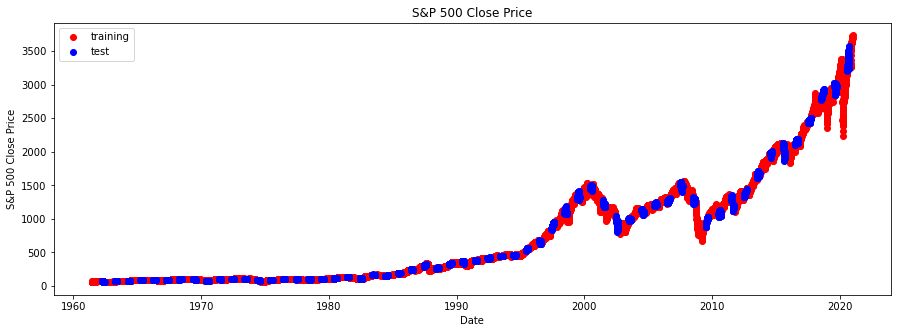

In [55]:
# Visualizing training dataset and test dataset
out_temp = np.concatenate((y_train_rnn[:, 0, [0]], 
                           y_train_rnn[:, 0, [0]],
                           y_train_rnn[:, 0, [0]]), axis=1)
price_train = sc.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate((y_test_rnn[:, 0, [0]], 
                           y_test_rnn[:, 0, [0]],
                           y_test_rnn[:, 0, [0]]), axis=1)
price_test = sc.inverse_transform(out_temp)[:, [0]]

plt.figure(figsize=(15, 5));
plt.plot(date_train_rnn, price_train[:,0], color = 'red', label = 'training', marker= 'o', linestyle='None')
plt.plot(date_test_rnn, price_test[:,0], color = 'blue', label = 'test', marker= 'o', linestyle='None')
plt.title('S&P 500 Close Price')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

### Train RNN model.

#### Construct RNN network.

In [56]:
rnn = RNN(input_size, output_size, hidden_size, num_layers)
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
loss_func = nn.MSELoss()
# show the rnn network structure
print(rnn)
# show the weights, bias and gradients
for name, param in rnn.named_parameters():
    print(name, "\t",  param.shape)

RNN(
  (rnn): RNN(3, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=4, bias=True)
)
rnn.weight_ih_l0 	 torch.Size([16, 3])
rnn.weight_hh_l0 	 torch.Size([16, 16])
rnn.bias_ih_l0 	 torch.Size([16])
rnn.bias_hh_l0 	 torch.Size([16])
fc.weight 	 torch.Size([4, 16])
fc.bias 	 torch.Size([4])


#### Start training RNN network.

In [57]:
loss_all_rnn = []
for epoch in range(num_epochs):
    # transfer the data into torch tensor
    inputs = Variable(torch.from_numpy(x_train_rnn).float())
    labels = Variable(torch.from_numpy(y_train_rnn).float())
    # set zero gradients
    optimizer.zero_grad()
    # forward propagation
    output, hidden = rnn(inputs)
    # calculate loss
    loss = loss_func(output.reshape(-1),labels.view(-1))
    # store the loss
    loss_all_rnn.append(loss.item())
    # backward propagation
    loss.backward(retain_graph=True)
    # plot the progress
    if (epoch % 10 == 0):
        print('Epoch: ', epoch, '| train loss: %.4f' % loss.item())
    # update weights
    optimizer.step()

Epoch:  0 | train loss: 0.0640
Epoch:  10 | train loss: 0.0440
Epoch:  20 | train loss: 0.0368
Epoch:  30 | train loss: 0.0315
Epoch:  40 | train loss: 0.0260
Epoch:  50 | train loss: 0.0202
Epoch:  60 | train loss: 0.0144
Epoch:  70 | train loss: 0.0094
Epoch:  80 | train loss: 0.0053
Epoch:  90 | train loss: 0.0029
Epoch:  100 | train loss: 0.0019
Epoch:  110 | train loss: 0.0012
Epoch:  120 | train loss: 0.0008
Epoch:  130 | train loss: 0.0006
Epoch:  140 | train loss: 0.0005
Epoch:  150 | train loss: 0.0005
Epoch:  160 | train loss: 0.0004
Epoch:  170 | train loss: 0.0004
Epoch:  180 | train loss: 0.0003
Epoch:  190 | train loss: 0.0003


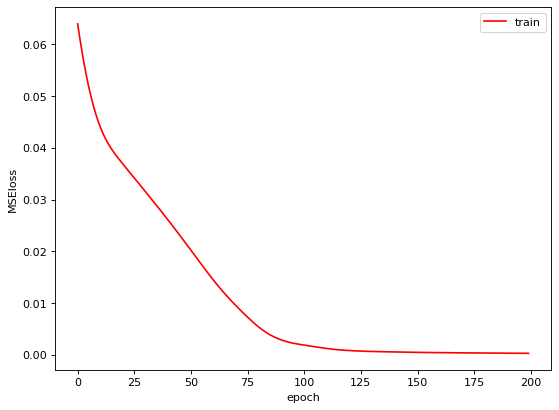

In [58]:
# plot the loss
plt.figure(figsize=[8,6], dpi=80)
plt.plot(np.array(loss_all_rnn), 'r', label = 'train')
plt.xlabel("epoch")
plt.ylabel("MSEloss")
plt.legend()

#### Show the prediction price and the real price in the next four date points(training dataset).

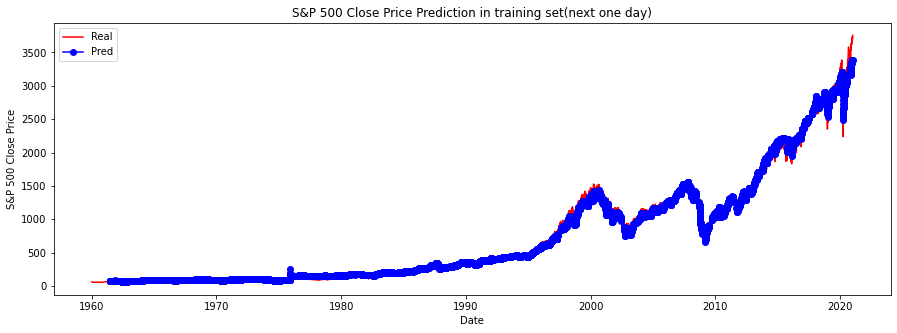

In [59]:
# plot the prediction price and the real price in the training dataset(next one day)
out_temp = np.concatenate((output.detach().numpy()[:, [0]], 
                           output.detach().numpy()[:, [0]],
                           output.detach().numpy()[:, [0]]), axis=1)
predicted_price = sc.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date, dataset_part[:,0], color = 'red', label = 'Real')
plt.plot(date_train_rnn, predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in training set(next one day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

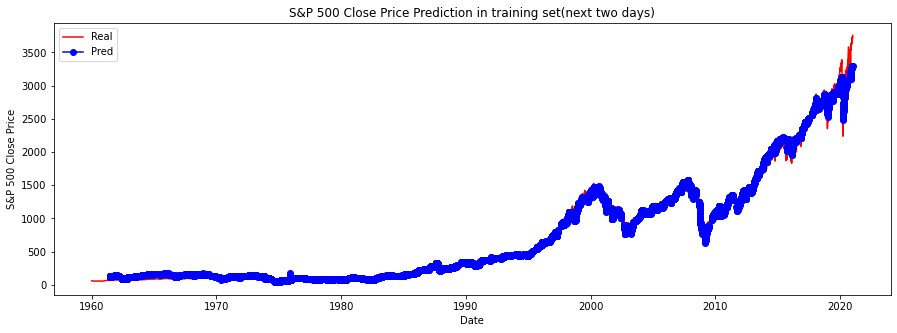

In [60]:
# plot the prediction price and the real price in the training dataset(next two days)
out_temp = np.concatenate((output.detach().numpy()[:, [1]], 
                           output.detach().numpy()[:, [1]],
                           output.detach().numpy()[:, [1]]), axis=1)
predicted_price = sc.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date, dataset_part[:,0], color = 'red', label = 'Real')
plt.plot(date_train_rnn, predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in training set(next two days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

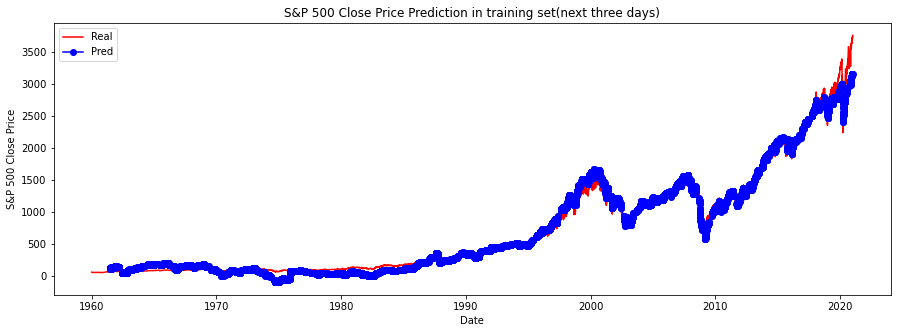

In [61]:
# plot the prediction price and the real price in the training dataset(next three days)
out_temp = np.concatenate((output.detach().numpy()[:, [2]], 
                           output.detach().numpy()[:, [2]],
                           output.detach().numpy()[:, [2]]), axis=1)
predicted_price = sc.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date, dataset_part[:,0], color = 'red', label = 'Real')
plt.plot(date_train_rnn, predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in training set(next three days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

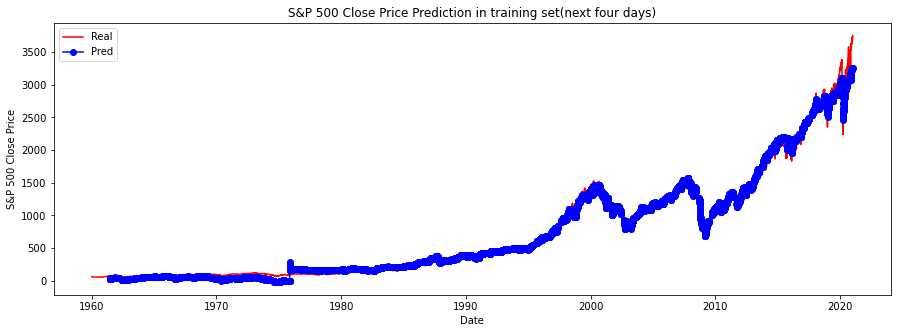

In [62]:
# plot the prediction price and the real price in the training dataset(next four days)
out_temp = np.concatenate((output.detach().numpy()[:, [3]], 
                           output.detach().numpy()[:, [3]],
                           output.detach().numpy()[:, [3]]), axis=1)
predicted_price = sc.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date, dataset_part[:,0], color = 'red', label = 'Real')
plt.plot(date_train_rnn, predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in training set(next four days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

## Test CNN and RNN accuracy over Test Data on which did not train, to determine how well the neural networks generalize -- specifically, in terms of predicting the next one, two, three, and four date points in the dataset.

### Accuracy will be computed in terms of error defined as prediction_error := |predicted_price - actual_price| / actual_price.

In [63]:
# compute prediction_error := (predicted_price - actual_price) / actual_price 
def prediction_error(pred,target):
    error = abs(pred - target)/target
    return error

### Graph prediction_error as a function of timestamp for all data in the Training Set.

In [64]:
# store mean error for the training dataset
mean_train = []
std_train = []
skewness_train = []
kurtosis_train = []

#### Calculate the prediction error for the next four date points(training dataset).

In [65]:
# predict next one day
train_inputs = Variable(torch.from_numpy(x_train_rnn).float())
# prevent tuple data type
output_train, _ = rnn(train_inputs)
output_temp = np.concatenate((output_train.detach().numpy()[:, [0]],
                            output_train.detach().numpy()[:, [0]],
                            output_train.detach().numpy()[:, [0]]), axis=1)
predicted_price_train = sc.inverse_transform(output_temp)[:, [0]]
output_temp = np.concatenate((y_train_rnn[:,:,0],y_train_rnn[:,:,0],y_train_rnn[:,:,0]), axis=1)
actual_price_train = sc.inverse_transform(output_temp)[:, [0]]
error_train_rnn_1 = prediction_error(predicted_price_train, actual_price_train)
mean_train.append(np.mean(error_train_rnn_1))
std_train.append(np.std(error_train_rnn_1))
skewness_train.append(stats.skew(error_train_rnn_1))
kurtosis_train.append(stats.kurtosis(error_train_rnn_1))

In [66]:
# predict next two days
train_inputs = Variable(torch.from_numpy(x_train_rnn).float())
# prevent tuple data type
output_train, _ = rnn(train_inputs)
output_temp = np.concatenate((output_train.detach().numpy()[:, [1]],
                            output_train.detach().numpy()[:, [1]],
                            output_train.detach().numpy()[:, [1]]), axis=1)
predicted_price_train = sc.inverse_transform(output_temp)[:, [0]]
output_temp = np.concatenate((y_train_rnn[:,:,1],y_train_rnn[:,:,1],y_train_rnn[:,:,1]), axis=1)
actual_price_train = sc.inverse_transform(output_temp)[:, [0]]
error_train_rnn_2 = prediction_error(predicted_price_train, actual_price_train)
mean_train.append(np.mean(error_train_rnn_2))
std_train.append(np.std(error_train_rnn_2))
skewness_train.append(stats.skew(error_train_rnn_2))
kurtosis_train.append(stats.kurtosis(error_train_rnn_2))

In [67]:
# predict next three days
train_inputs = Variable(torch.from_numpy(x_train_rnn).float())
# prevent tuple data type
output_train, _ = rnn(train_inputs)
output_temp = np.concatenate((output_train.detach().numpy()[:, [2]],
                            output_train.detach().numpy()[:, [2]],
                            output_train.detach().numpy()[:, [2]]), axis=1)
predicted_price_train = sc.inverse_transform(output_temp)[:, [0]]
output_temp = np.concatenate((y_train_rnn[:,:,2],y_train_rnn[:,:,2],y_train_rnn[:,:,2]), axis=1)
actual_price_train = sc.inverse_transform(output_temp)[:, [0]]
error_train_rnn_3 = prediction_error(predicted_price_train, actual_price_train)
mean_train.append(np.mean(error_train_rnn_3))
std_train.append(np.std(error_train_rnn_3))
skewness_train.append(stats.skew(error_train_rnn_3))
kurtosis_train.append(stats.kurtosis(error_train_rnn_3))

In [68]:
# predict next four days
train_inputs = Variable(torch.from_numpy(x_train_rnn).float())
# prevent tuple data type
output_train, _ = rnn(train_inputs)
output_temp = np.concatenate((output_train.detach().numpy()[:, [3]],
                            output_train.detach().numpy()[:, [3]],
                            output_train.detach().numpy()[:, [3]]), axis=1)
predicted_price_train = sc.inverse_transform(output_temp)[:, [0]]
output_temp = np.concatenate((y_train_rnn[:,:,3],y_train_rnn[:,:,3],y_train_rnn[:,:,3]), axis=1)
actual_price_train = sc.inverse_transform(output_temp)[:, [0]]
error_train_rnn_4 = prediction_error(predicted_price_train, actual_price_train)
mean_train.append(np.mean(error_train_rnn_4))
std_train.append(np.std(error_train_rnn_4))
skewness_train.append(stats.skew(error_train_rnn_4))
kurtosis_train.append(stats.kurtosis(error_train_rnn_4))

#### Graph the prediction error as a function of timestamp(training dataset).

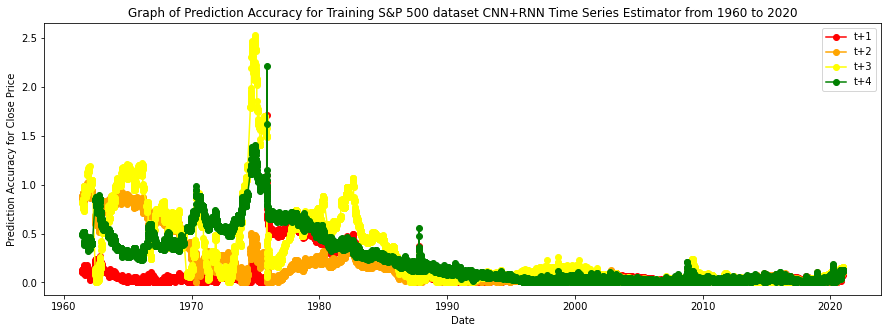

In [69]:
plt.figure(figsize=(15, 5));
plt.plot(date_train_rnn, error_train_rnn_1, color = 'red', label = 't+1', marker= 'o')
plt.plot(date_train_rnn+ pd.Timedelta('1 day'), error_train_rnn_2, color = 'orange', label = 't+2', marker= 'o')
plt.plot(date_train_rnn+ pd.Timedelta('2 day'), error_train_rnn_3, color = 'yellow', label = 't+3', marker= 'o')
plt.plot(date_train_rnn+ pd.Timedelta('3 day'), error_train_rnn_4, color = 'green', label = 't+4', marker= 'o')
plt.title('Graph of Prediction Accuracy for Training S&P 500 dataset CNN+RNN Time Series Estimator from 1960 to 2020')
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Close Price')
plt.legend()
plt.show()

### Graph prediction_error as a function of timestamp for all data in the Testing Set.

#### Show the prediction price and the real price in the next four date points(testing dataset).

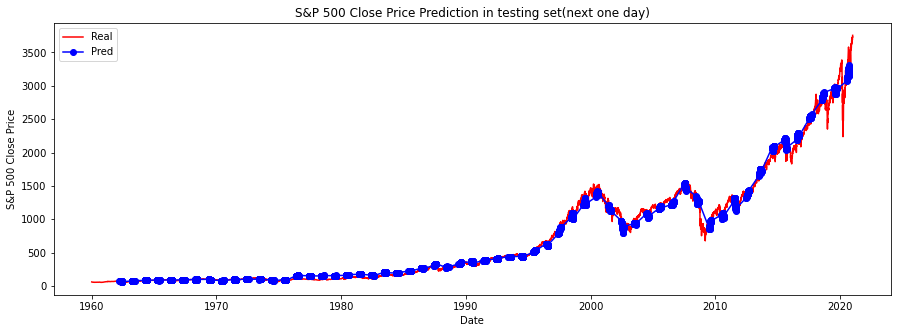

In [70]:
# transfer test data to tensor
test_input = Variable(torch.from_numpy(x_test_rnn).float())
# prevent tuple data type
# get output of the test dataset
output_test, _ = rnn(test_input)
# plot the prediction price and the real price in the training dataset(next one day)
out_temp = np.concatenate((output_test.detach().numpy()[:, [0]], 
                           output_test.detach().numpy()[:, [0]],
                           output_test.detach().numpy()[:, [0]]), axis=1)
predicted_price = sc.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date, dataset_part[:,0], color = 'red', label = 'Real')
plt.plot(date_test_rnn, predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in testing set(next one day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

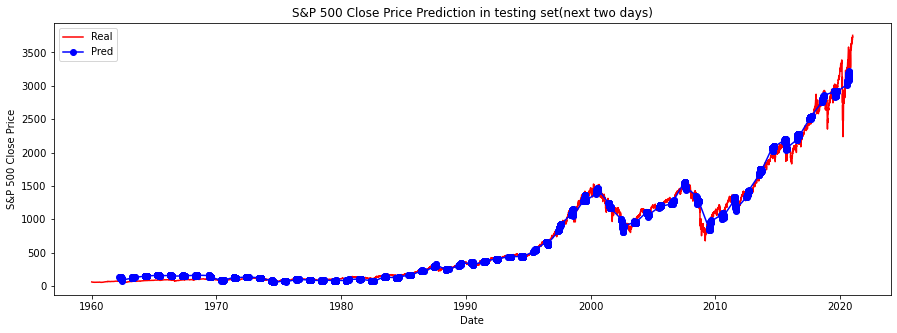

In [71]:
# plot the prediction price and the real price in the training dataset(next two days)
out_temp = np.concatenate((output_test.detach().numpy()[:, [1]], 
                           output_test.detach().numpy()[:, [1]],
                           output_test.detach().numpy()[:, [1]]), axis=1)
predicted_price = sc.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date, dataset_part[:,0], color = 'red', label = 'Real')
plt.plot(date_test_rnn, predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in testing set(next two days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

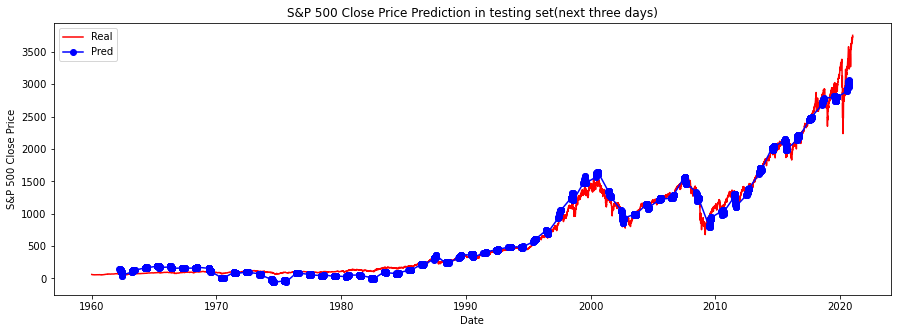

In [72]:
# plot the prediction price and the real price in the training dataset(next three days)
out_temp = np.concatenate((output_test.detach().numpy()[:, [2]], 
                           output_test.detach().numpy()[:, [2]],
                           output_test.detach().numpy()[:, [2]]), axis=1)
predicted_price = sc.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date, dataset_part[:,0], color = 'red', label = 'Real')
plt.plot(date_test_rnn, predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in testing set(next three days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

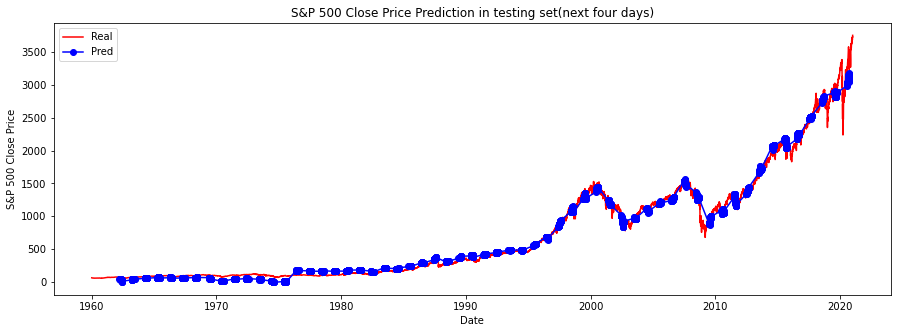

In [73]:
# plot the prediction price and the real price in the training dataset(next four days)
out_temp = np.concatenate((output_test.detach().numpy()[:, [3]], 
                           output_test.detach().numpy()[:, [3]],
                           output_test.detach().numpy()[:, [3]]), axis=1)
predicted_price = sc.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date, dataset_part[:,0], color = 'red', label = 'Real')
plt.plot(date_test_rnn, predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in testing set(next four days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

#### Calculate the prediction error for the next four date points(testing dataset).

In [74]:
# store mean error for the test dataset
mean_test = []
std_test = []
skewness_test = []
kurtosis_test = []

In [75]:
# predict next one day
output_temp = np.concatenate((output_test.detach().numpy()[:, [0]],
                            output_test.detach().numpy()[:, [0]],
                            output_test.detach().numpy()[:, [0]]), axis=1)
predicted_price_test = sc.inverse_transform(output_temp)[:, [0]]
output_temp = np.concatenate((y_test_rnn[:,:,0],y_test_rnn[:,:,0],y_test_rnn[:,:,0]), axis=1)
actual_price_test = sc.inverse_transform(output_temp)[:, [0]]
error_test_rnn_1 = prediction_error(predicted_price_test, actual_price_test)
mean_test.append(np.mean(error_test_rnn_1))
std_test.append(np.std(error_test_rnn_1))
skewness_test.append(stats.skew(error_test_rnn_1))
kurtosis_test.append(stats.kurtosis(error_test_rnn_1))

In [76]:
# predict next two days
output_temp = np.concatenate((output_test.detach().numpy()[:, [1]],
                            output_test.detach().numpy()[:, [1]],
                            output_test.detach().numpy()[:, [1]]), axis=1)
predicted_price_test = sc.inverse_transform(output_temp)[:, [0]]
output_temp = np.concatenate((y_test_rnn[:,:,1],y_test_rnn[:,:,1],y_test_rnn[:,:,1]), axis=1)
actual_price_test = sc.inverse_transform(output_temp)[:, [0]]
error_test_rnn_2 = prediction_error(predicted_price_test, actual_price_test)
mean_test.append(np.mean(error_test_rnn_2))
std_test.append(np.std(error_test_rnn_2))
skewness_test.append(stats.skew(error_test_rnn_2))
kurtosis_test.append(stats.kurtosis(error_test_rnn_2))

In [77]:
# predict next three days
output_temp = np.concatenate((output_test.detach().numpy()[:, [2]],
                            output_test.detach().numpy()[:, [2]],
                            output_test.detach().numpy()[:, [2]]), axis=1)
predicted_price_test = sc.inverse_transform(output_temp)[:, [0]]
output_temp = np.concatenate((y_test_rnn[:,:,2],y_test_rnn[:,:,2],y_test_rnn[:,:,2]), axis=1)
actual_price_test = sc.inverse_transform(output_temp)[:, [0]]
error_test_rnn_3 = prediction_error(predicted_price_test, actual_price_test)
mean_test.append(np.mean(error_test_rnn_3))
std_test.append(np.std(error_test_rnn_3))
skewness_test.append(stats.skew(error_test_rnn_3))
kurtosis_test.append(stats.kurtosis(error_test_rnn_3))

In [78]:
# predict next four days
output_temp = np.concatenate((output_test.detach().numpy()[:, [3]],
                            output_test.detach().numpy()[:, [3]],
                            output_test.detach().numpy()[:, [3]]), axis=1)
predicted_price_test = sc.inverse_transform(output_temp)[:, [0]]
output_temp = np.concatenate((y_test_rnn[:,:,3],y_test_rnn[:,:,3],y_test_rnn[:,:,3]), axis=1)
actual_price_test = sc.inverse_transform(output_temp)[:, [0]]
error_test_rnn_4 = prediction_error(predicted_price_test, actual_price_test)
mean_test.append(np.mean(error_test_rnn_4))
std_test.append(np.std(error_test_rnn_4))
skewness_test.append(stats.skew(error_test_rnn_4))
kurtosis_test.append(stats.kurtosis(error_test_rnn_4))

#### Graph the prediction error as a function of timestamp(testing dataset).

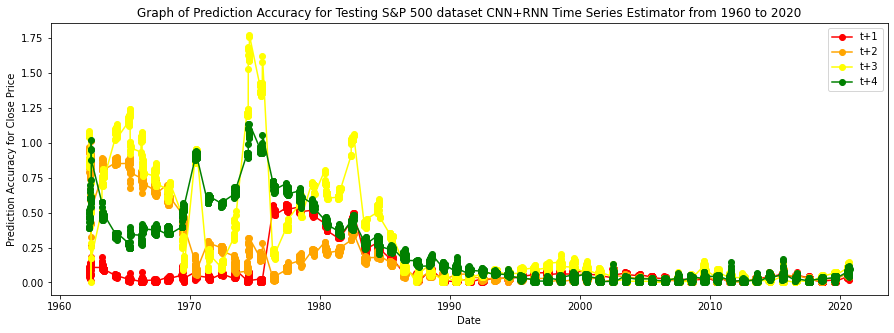

In [79]:
plt.figure(figsize=(15, 5));
plt.plot(date_test_rnn, error_test_rnn_1, color = 'red', label = 't+1', marker= 'o')
plt.plot(date_test_rnn+ pd.Timedelta('1 day'), error_test_rnn_2, color = 'orange', label = 't+2', marker= 'o')
plt.plot(date_test_rnn+ pd.Timedelta('2 day'), error_test_rnn_3, color = 'yellow', label = 't+3', marker= 'o')
plt.plot(date_test_rnn+ pd.Timedelta('3 day'), error_test_rnn_4, color = 'green', label = 't+4', marker= 'o')
plt.title('Graph of Prediction Accuracy for Testing S&P 500 dataset CNN+RNN Time Series Estimator from 1960 to 2020')
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Close Price')
plt.legend()
plt.show()

## Optimize CNN+RNN algorithm's performance to yield maximum achievable accuracy.

### Construct a brand new dataset structure.

In [80]:
x_opt = []
y_opt = []
date_opt = []
for i in range(window_size,n_rows - window_size - output_size + 1):
    x_opt.append(dataset_part_scaled[i:i+window_size,])
    y_opt.append(dataset_part_scaled[i+window_size:i+window_size+output_size,0])
    date_opt.append(date_data[i+window_size])

x_opt, y_opt, date_opt = np.array(x_opt), np.array(y_opt), np.array(date_opt)
y_opt = np.reshape(y_opt, (y_opt.shape[0],1, y_opt.shape[1]))

In [81]:
# split dataset into 80% train and 20% test
x_train_rnn_opt = []
y_train_rnn_opt = []
date_train_rnn_opt = []
x_test_rnn_opt = []
y_test_rnn_opt = []
date_test_rnn_opt = []
for i in range(x_opt.shape[0]):
    if(i%253>=200):
        x_test_rnn_opt.append(x_opt[i])
        y_test_rnn_opt.append(y_opt[i])
        date_test_rnn_opt.append(date_opt[i])
    else:
        x_train_rnn_opt.append(x_opt[i])
        y_train_rnn_opt.append(y_opt[i])
        date_train_rnn_opt.append(date_opt[i])
x_train_rnn_opt, y_train_rnn_opt, date_train_rnn_opt = np.array(x_train_rnn_opt), np.array(y_train_rnn_opt), np.array(date_train_rnn_opt)
x_test_rnn_opt, y_test_rnn_opt, date_test_rnn_opt = np.array(x_test_rnn_opt), np.array(y_test_rnn_opt), np.array(date_test_rnn_opt)

### Construct a new RNN network to achieve more accuracy.

In [82]:
input_size_opt = 3
output_size_opt = 4
hidden_size_opt = 32
num_layers_opt = 2
learning_rate_opt = 0.001
num_epochs_opt = 200
window_size_opt = 180

rnn_opt = RNN(input_size_opt, output_size_opt, hidden_size_opt, num_layers_opt)
optimizer_opt = torch.optim.Adam(rnn_opt.parameters(), lr=learning_rate_opt)
loss_fn_opt = torch.nn.MSELoss()

In [83]:
rnn_opt

RNN(
  (rnn): RNN(3, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=4, bias=True)
)

In [84]:
# show the parameters of the model
for name, param in rnn_opt.named_parameters():
    if param.requires_grad:
        print(name, '\t', param.data.shape)

rnn.weight_ih_l0 	 torch.Size([32, 3])
rnn.weight_hh_l0 	 torch.Size([32, 32])
rnn.bias_ih_l0 	 torch.Size([32])
rnn.bias_hh_l0 	 torch.Size([32])
rnn.weight_ih_l1 	 torch.Size([32, 32])
rnn.weight_hh_l1 	 torch.Size([32, 32])
rnn.bias_ih_l1 	 torch.Size([32])
rnn.bias_hh_l1 	 torch.Size([32])
fc.weight 	 torch.Size([4, 32])
fc.bias 	 torch.Size([4])


### Begin training.

In [85]:
for epoch in range(num_epochs_opt):
    input = Variable(torch.from_numpy(x_train_rnn_opt)).float()
    label = Variable(torch.from_numpy(y_train_rnn_opt)).float()
    output_opt, hidden_opt = rnn_opt(input)
    loss_opt = loss_fn_opt(output_opt.reshape(-1), label.view(-1))

    if (epoch+1) % 10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs_opt, loss_opt.item()))
    
    optimizer_opt.zero_grad()
    loss_opt.backward(retain_graph=True)
    optimizer_opt.step()

Epoch [10/200], Loss: 0.0424
Epoch [20/200], Loss: 0.0301
Epoch [30/200], Loss: 0.0155
Epoch [40/200], Loss: 0.0093
Epoch [50/200], Loss: 0.0061
Epoch [60/200], Loss: 0.0036
Epoch [70/200], Loss: 0.0011
Epoch [80/200], Loss: 0.0007
Epoch [90/200], Loss: 0.0004
Epoch [100/200], Loss: 0.0004
Epoch [110/200], Loss: 0.0003
Epoch [120/200], Loss: 0.0003
Epoch [130/200], Loss: 0.0003
Epoch [140/200], Loss: 0.0002
Epoch [150/200], Loss: 0.0002
Epoch [160/200], Loss: 0.0002
Epoch [170/200], Loss: 0.0002
Epoch [180/200], Loss: 0.0002
Epoch [190/200], Loss: 0.0002
Epoch [200/200], Loss: 0.0002


### Plot the optimized network results.

#### Show the prediction price and the real price in the next four date points(training dataset).

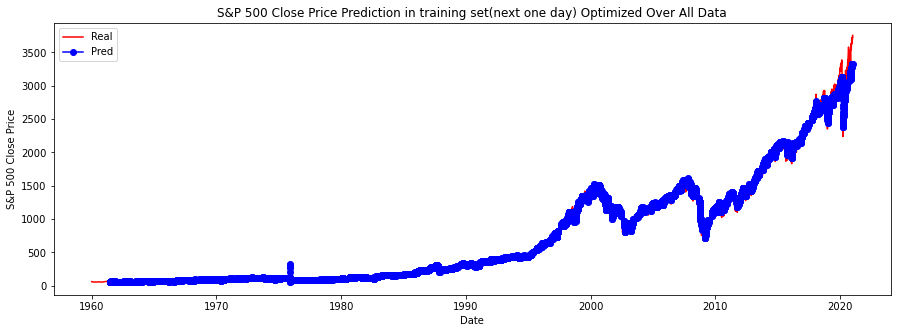

In [86]:
# plot the prediction price and the real price in the training dataset(next one day)
out_temp = np.concatenate((output_opt.detach().numpy()[:, [0]], 
                           output_opt.detach().numpy()[:, [0]],
                           output_opt.detach().numpy()[:, [0]]), axis=1)
predicted_price = sc.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date, dataset_part[:,0], color = 'red', label = 'Real')
plt.plot(date_train_rnn_opt, predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in training set(next one day) Optimized Over All Data')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

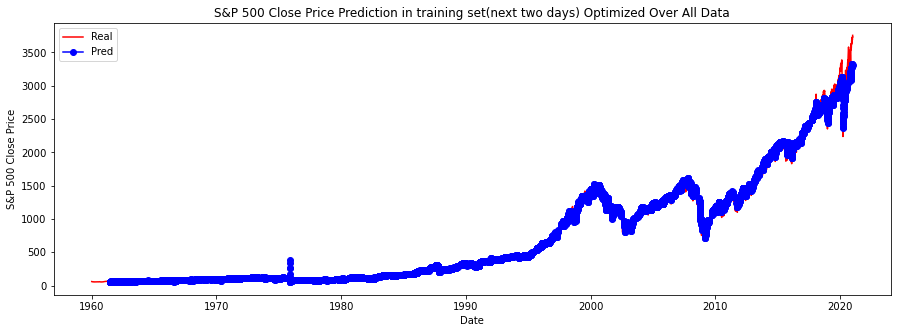

In [87]:
# plot the prediction price and the real price in the training dataset(next two days)
out_temp = np.concatenate((output_opt.detach().numpy()[:, [1]], 
                           output_opt.detach().numpy()[:, [1]],
                           output_opt.detach().numpy()[:, [1]]), axis=1)
predicted_price = sc.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date, dataset_part[:,0], color = 'red', label = 'Real')
plt.plot(date_train_rnn_opt, predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in training set(next two days) Optimized Over All Data')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

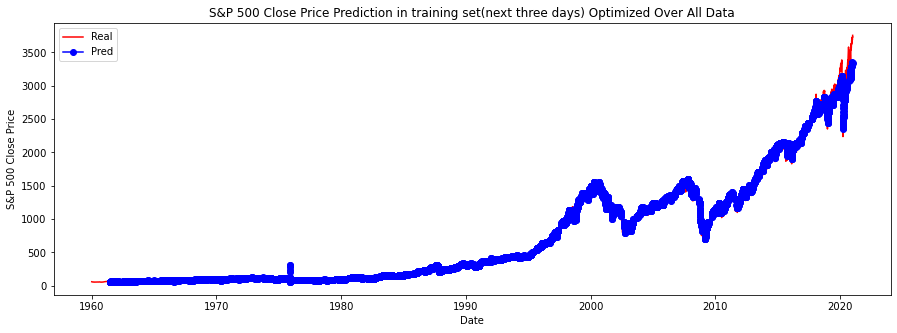

In [96]:
# plot the prediction price and the real price in the training dataset(next three days)
out_temp = np.concatenate((output_opt.detach().numpy()[:, [2]], 
                           output_opt.detach().numpy()[:, [2]],
                           output_opt.detach().numpy()[:, [2]]), axis=1)
predicted_price = sc.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date, dataset_part[:,0], color = 'red', label = 'Real')
plt.plot(date_train_rnn_opt, predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in training set(next three days) Optimized Over All Data')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

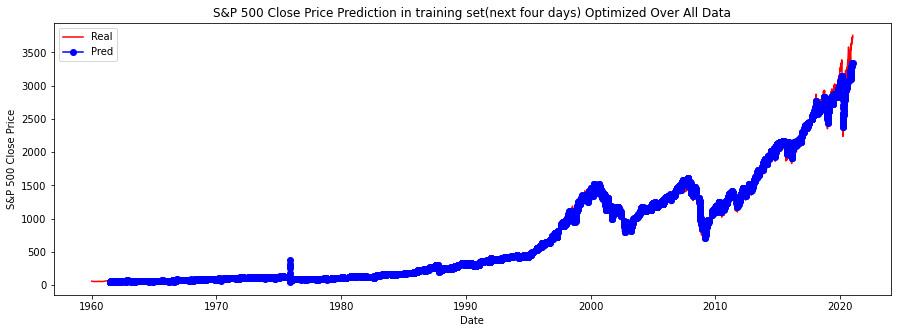

In [89]:
# plot the prediction price and the real price in the training dataset(next four days)
out_temp = np.concatenate((output_opt.detach().numpy()[:, [3]], 
                           output_opt.detach().numpy()[:, [3]],
                           output_opt.detach().numpy()[:, [3]]), axis=1)
predicted_price = sc.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date, dataset_part[:,0], color = 'red', label = 'Real')
plt.plot(date_train_rnn_opt, predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in training set(next four days) Optimized Over All Data')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

#### Graph prediction_error as a function of timestamp for all data in the Training Set.

In [90]:
# store mean error for the training dataset
mean_train_opt = []
std_train_opt = []
skewness_train_opt = []
kurtosis_train_opt = []

##### Calculate the prediction error for the next four date points(training dataset).

In [91]:
# predict next one day
train_inputs_opt = Variable(torch.from_numpy(x_train_rnn_opt).float())
# prevent tuple data type
output_train_opt, _ = rnn_opt(train_inputs_opt)
output_temp = np.concatenate((output_train_opt.detach().numpy()[:, [0]],
                            output_train_opt.detach().numpy()[:, [0]],
                            output_train_opt.detach().numpy()[:, [0]]), axis=1)
predicted_price_train_opt = sc.inverse_transform(output_temp)[:, [0]]
output_temp = np.concatenate((y_train_rnn_opt[:,:,0],y_train_rnn_opt[:,:,0],y_train_rnn_opt[:,:,0]), axis=1)
actual_price_train_opt = sc.inverse_transform(output_temp)[:, [0]]
error_train_rnn_1_opt = prediction_error(predicted_price_train_opt, actual_price_train_opt)
mean_train_opt.append(np.mean(error_train_rnn_1_opt))
std_train_opt.append(np.std(error_train_rnn_1_opt))
skewness_train_opt.append(stats.skew(error_train_rnn_1_opt))
kurtosis_train_opt.append(stats.kurtosis(error_train_rnn_1_opt))

In [92]:
# predict next two days
output_temp = np.concatenate((output_train_opt.detach().numpy()[:, [1]],
                            output_train_opt.detach().numpy()[:, [1]],
                            output_train_opt.detach().numpy()[:, [1]]), axis=1)
predicted_price_train_opt = sc.inverse_transform(output_temp)[:, [0]]
output_temp = np.concatenate((y_train_rnn_opt[:,:,1],y_train_rnn_opt[:,:,1],y_train_rnn_opt[:,:,1]), axis=1)
actual_price_train_opt = sc.inverse_transform(output_temp)[:, [0]]
error_train_rnn_2_opt = prediction_error(predicted_price_train_opt, actual_price_train_opt)
mean_train_opt.append(np.mean(error_train_rnn_2_opt))
std_train_opt.append(np.std(error_train_rnn_2_opt))
skewness_train_opt.append(stats.skew(error_train_rnn_2_opt))
kurtosis_train_opt.append(stats.kurtosis(error_train_rnn_2_opt))

In [93]:
# predict next three days
output_temp = np.concatenate((output_train_opt.detach().numpy()[:, [2]],
                            output_train_opt.detach().numpy()[:, [2]],
                            output_train_opt.detach().numpy()[:, [2]]), axis=1)
predicted_price_train_opt = sc.inverse_transform(output_temp)[:, [0]]
output_temp = np.concatenate((y_train_rnn_opt[:,:,2],y_train_rnn_opt[:,:,2],y_train_rnn_opt[:,:,2]), axis=1)
actual_price_train_opt = sc.inverse_transform(output_temp)[:, [0]]
error_train_rnn_3_opt = prediction_error(predicted_price_train_opt, actual_price_train_opt)
mean_train_opt.append(np.mean(error_train_rnn_3_opt))
std_train_opt.append(np.std(error_train_rnn_3_opt))
skewness_train_opt.append(stats.skew(error_train_rnn_3_opt))
kurtosis_train_opt.append(stats.kurtosis(error_train_rnn_3_opt))

In [94]:
# predict next four days
output_temp = np.concatenate((output_train_opt.detach().numpy()[:, [3]],
                            output_train_opt.detach().numpy()[:, [3]],
                            output_train_opt.detach().numpy()[:, [3]]), axis=1)
predicted_price_train_opt = sc.inverse_transform(output_temp)[:, [0]]
output_temp = np.concatenate((y_train_rnn_opt[:,:,3],y_train_rnn_opt[:,:,3],y_train_rnn_opt[:,:,3]), axis=1)
actual_price_train_opt = sc.inverse_transform(output_temp)[:, [0]]
error_train_rnn_4_opt = prediction_error(predicted_price_train_opt, actual_price_train_opt)
mean_train_opt.append(np.mean(error_train_rnn_4_opt))
std_train_opt.append(np.std(error_train_rnn_4_opt))
skewness_train_opt.append(stats.skew(error_train_rnn_4_opt))
kurtosis_train_opt.append(stats.kurtosis(error_train_rnn_4_opt))

##### Graph the prediction error as a function of timestamp(training dataset).

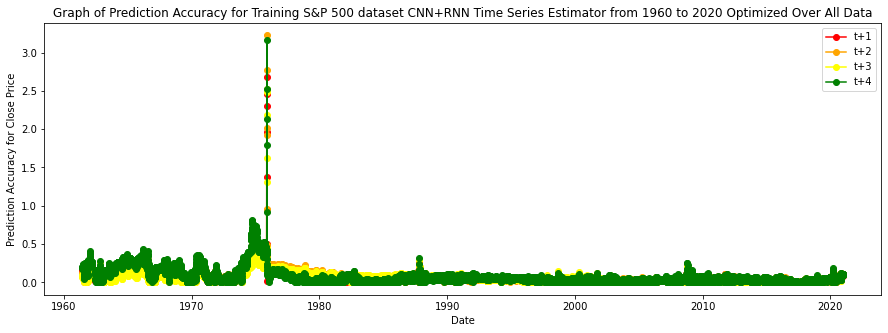

In [95]:
plt.figure(figsize=(15, 5));
plt.plot(date_train_rnn_opt, error_train_rnn_1_opt, color = 'red', label = 't+1', marker= 'o')
plt.plot(date_train_rnn_opt+ pd.Timedelta('1 day'), error_train_rnn_2_opt, color = 'orange', label = 't+2', marker= 'o')
plt.plot(date_train_rnn_opt+ pd.Timedelta('2 day'), error_train_rnn_3_opt, color = 'yellow', label = 't+3', marker= 'o')
plt.plot(date_train_rnn_opt+ pd.Timedelta('3 day'), error_train_rnn_4_opt, color = 'green', label = 't+4', marker= 'o')
plt.title('Graph of Prediction Accuracy for Training S&P 500 dataset CNN+RNN Time Series Estimator from 1960 to 2020 Optimized Over All Data')
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Close Price')
plt.legend()
plt.show()

##### Show the graph separately.

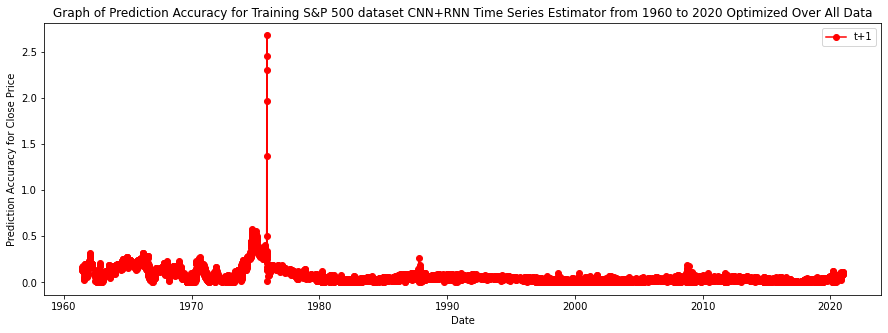

In [97]:
plt.figure(figsize=(15, 5));
plt.plot(date_train_rnn_opt, error_train_rnn_1_opt, color = 'red', label = 't+1', marker= 'o')
plt.title('Graph of Prediction Accuracy for Training S&P 500 dataset CNN+RNN Time Series Estimator from 1960 to 2020 Optimized Over All Data')
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Close Price')
plt.legend()
plt.show()

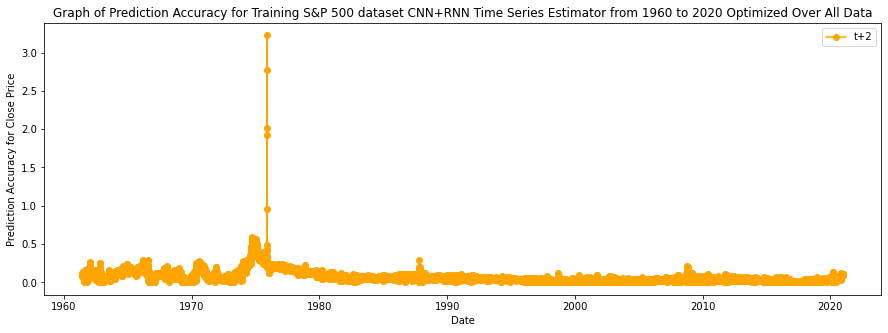

In [99]:
plt.figure(figsize=(15, 5));
plt.plot(date_train_rnn_opt+ pd.Timedelta('1 day'), error_train_rnn_2_opt, color = 'orange', label = 't+2', marker= 'o')
plt.title('Graph of Prediction Accuracy for Training S&P 500 dataset CNN+RNN Time Series Estimator from 1960 to 2020 Optimized Over All Data')
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Close Price')
plt.legend()
plt.show()

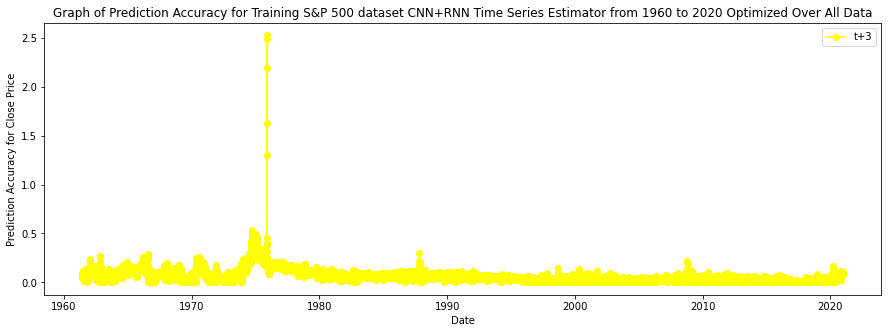

In [100]:
plt.figure(figsize=(15, 5));
plt.plot(date_train_rnn_opt+ pd.Timedelta('2 day'), error_train_rnn_3_opt, color = 'yellow', label = 't+3', marker= 'o')
plt.title('Graph of Prediction Accuracy for Training S&P 500 dataset CNN+RNN Time Series Estimator from 1960 to 2020 Optimized Over All Data')
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Close Price')
plt.legend()
plt.show()

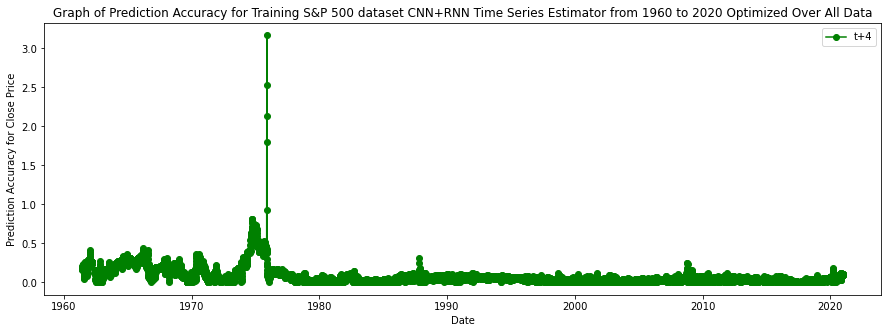

In [101]:
plt.figure(figsize=(15, 5));
plt.plot(date_train_rnn_opt+ pd.Timedelta('3 day'), error_train_rnn_4_opt, color = 'green', label = 't+4', marker= 'o')
plt.title('Graph of Prediction Accuracy for Training S&P 500 dataset CNN+RNN Time Series Estimator from 1960 to 2020 Optimized Over All Data')
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Close Price')
plt.legend()
plt.show()

#### Show the prediction price and the real price in the next four date points(testing dataset).

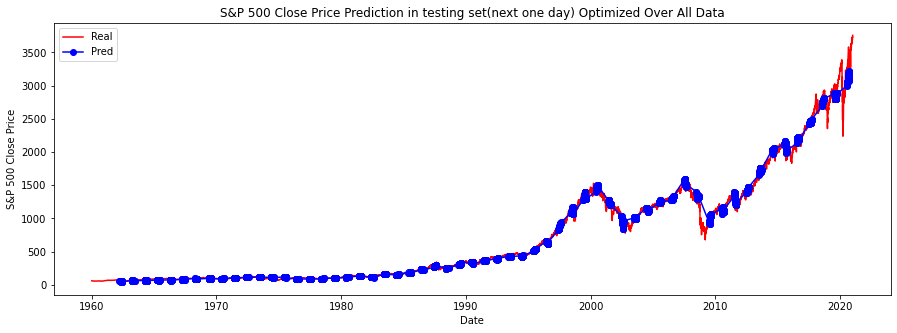

In [102]:
# transfer test data to tensor
test_input_opt = Variable(torch.from_numpy(x_test_rnn_opt).float())
# prevent tuple data type
# get output of the test dataset
output_test_opt, _ = rnn_opt(test_input_opt)
# plot the prediction price and the real price in the training dataset(next one day) optimized
out_temp = np.concatenate((output_test_opt.detach().numpy()[:, [0]], 
                           output_test_opt.detach().numpy()[:, [0]],
                           output_test_opt.detach().numpy()[:, [0]]), axis=1)
predicted_price_opt = sc.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date, dataset_part[:,0], color = 'red', label = 'Real')
plt.plot(date_test_rnn_opt, predicted_price_opt, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in testing set(next one day) Optimized Over All Data')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

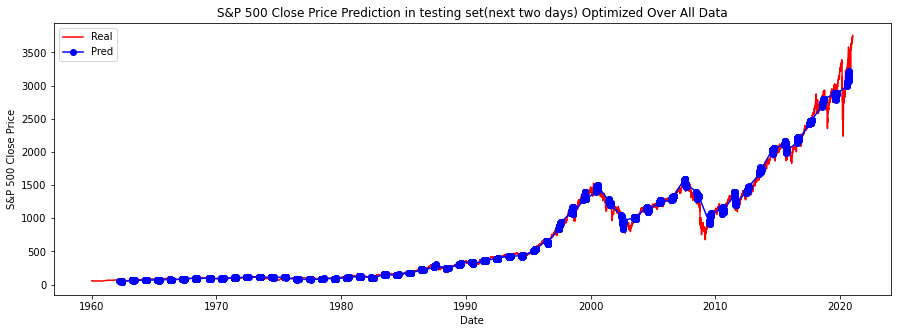

In [103]:
# plot the prediction price and the real price in the training dataset(next two days) optimized
out_temp = np.concatenate((output_test_opt.detach().numpy()[:, [1]], 
                           output_test_opt.detach().numpy()[:, [1]],
                           output_test_opt.detach().numpy()[:, [1]]), axis=1)
predicted_price_opt = sc.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date, dataset_part[:,0], color = 'red', label = 'Real')
plt.plot(date_test_rnn_opt, predicted_price_opt, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in testing set(next two days) Optimized Over All Data')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

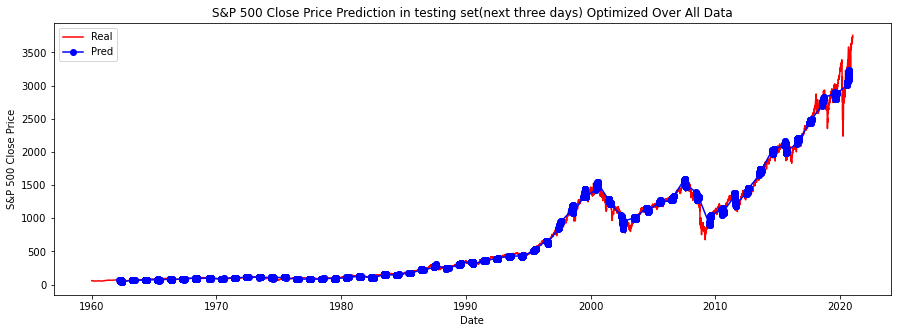

In [104]:
# plot the prediction price and the real price in the training dataset(next three days) optimized
out_temp = np.concatenate((output_test_opt.detach().numpy()[:, [2]], 
                           output_test_opt.detach().numpy()[:, [2]],
                           output_test_opt.detach().numpy()[:, [2]]), axis=1)
predicted_price_opt = sc.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date, dataset_part[:,0], color = 'red', label = 'Real')
plt.plot(date_test_rnn_opt, predicted_price_opt, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in testing set(next three days) Optimized Over All Data')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

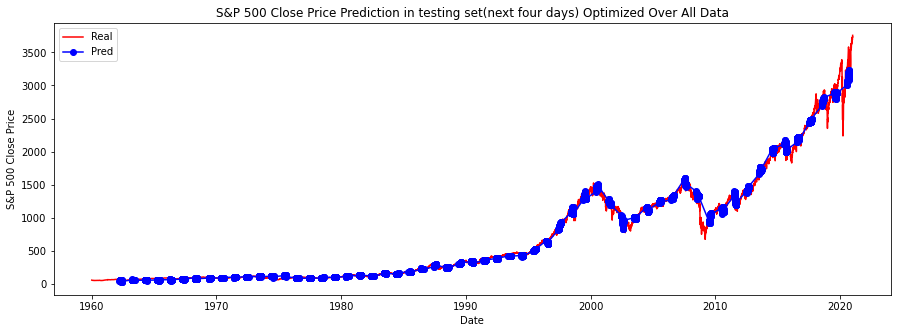

In [105]:
# plot the prediction price and the real price in the training dataset(next four days) optimized
out_temp = np.concatenate((output_test_opt.detach().numpy()[:, [3]], 
                           output_test_opt.detach().numpy()[:, [3]],
                           output_test_opt.detach().numpy()[:, [3]]), axis=1)
predicted_price_opt = sc.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date, dataset_part[:,0], color = 'red', label = 'Real')
plt.plot(date_test_rnn_opt, predicted_price_opt, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in testing set(next four days) Optimized Over All Data')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

#### Graph prediction_error as a function of timestamp for all data in the Testing Set.

In [106]:
# store mean error for the testing dataset
mean_test_opt = []
std_test_opt = []
skewness_test_opt = []
kurtosis_test_opt = []

##### Calculate the prediction error for the next four date points(testing dataset).

In [107]:
# predict next one day
test_inputs_opt = Variable(torch.from_numpy(x_test_rnn_opt).float())
# prevent tuple data type
output_test_opt, _ = rnn_opt(test_inputs_opt)
output_temp = np.concatenate((output_test_opt.detach().numpy()[:, [0]],
                            output_test_opt.detach().numpy()[:, [0]],
                            output_test_opt.detach().numpy()[:, [0]]), axis=1)
predicted_price_test_opt = sc.inverse_transform(output_temp)[:, [0]]
output_temp = np.concatenate((y_test_rnn_opt[:,:,0],y_test_rnn_opt[:,:,0],y_test_rnn_opt[:,:,0]), axis=1)
actual_price_test_opt = sc.inverse_transform(output_temp)[:, [0]]
error_test_rnn_1_opt = prediction_error(predicted_price_test_opt, actual_price_test_opt)
mean_test_opt.append(np.mean(error_test_rnn_1_opt))
std_test_opt.append(np.std(error_test_rnn_1_opt))
skewness_test_opt.append(stats.skew(error_test_rnn_1_opt))
kurtosis_test_opt.append(stats.kurtosis(error_test_rnn_1_opt))

In [108]:
# predict next two days
output_temp = np.concatenate((output_test_opt.detach().numpy()[:, [1]],
                            output_test_opt.detach().numpy()[:, [1]],
                            output_test_opt.detach().numpy()[:, [1]]), axis=1)
predicted_price_test_opt = sc.inverse_transform(output_temp)[:, [0]]
output_temp = np.concatenate((y_test_rnn_opt[:,:,1],y_test_rnn_opt[:,:,1],y_test_rnn_opt[:,:,1]), axis=1)
actual_price_test_opt = sc.inverse_transform(output_temp)[:, [0]]
error_test_rnn_2_opt = prediction_error(predicted_price_test_opt, actual_price_test_opt)
mean_test_opt.append(np.mean(error_test_rnn_2_opt))
std_test_opt.append(np.std(error_test_rnn_2_opt))
skewness_test_opt.append(stats.skew(error_test_rnn_2_opt))
kurtosis_test_opt.append(stats.kurtosis(error_test_rnn_2_opt))

In [109]:
# predict next three days
output_temp = np.concatenate((output_test_opt.detach().numpy()[:, [2]],
                            output_test_opt.detach().numpy()[:, [2]],
                            output_test_opt.detach().numpy()[:, [2]]), axis=1)
predicted_price_test_opt = sc.inverse_transform(output_temp)[:, [0]]
output_temp = np.concatenate((y_test_rnn_opt[:,:,2],y_test_rnn_opt[:,:,2],y_test_rnn_opt[:,:,2]), axis=1)
actual_price_test_opt = sc.inverse_transform(output_temp)[:, [0]]
error_test_rnn_3_opt = prediction_error(predicted_price_test_opt, actual_price_test_opt)
mean_test_opt.append(np.mean(error_test_rnn_3_opt))
std_test_opt.append(np.std(error_test_rnn_3_opt))
skewness_test_opt.append(stats.skew(error_test_rnn_3_opt))
kurtosis_test_opt.append(stats.kurtosis(error_test_rnn_3_opt))

In [110]:
# predict next four days
output_temp = np.concatenate((output_test_opt.detach().numpy()[:, [3]],
                            output_test_opt.detach().numpy()[:, [3]],
                            output_test_opt.detach().numpy()[:, [3]]), axis=1)
predicted_price_test_opt = sc.inverse_transform(output_temp)[:, [0]]
output_temp = np.concatenate((y_test_rnn_opt[:,:,3],y_test_rnn_opt[:,:,3],y_test_rnn_opt[:,:,3]), axis=1)
actual_price_test_opt = sc.inverse_transform(output_temp)[:, [0]]
error_test_rnn_4_opt = prediction_error(predicted_price_test_opt, actual_price_test_opt)
mean_test_opt.append(np.mean(error_test_rnn_4_opt))
std_test_opt.append(np.std(error_test_rnn_4_opt))
skewness_test_opt.append(stats.skew(error_test_rnn_4_opt))
kurtosis_test_opt.append(stats.kurtosis(error_test_rnn_4_opt))

##### Graph the prediction error as a function of timestamp(training dataset).

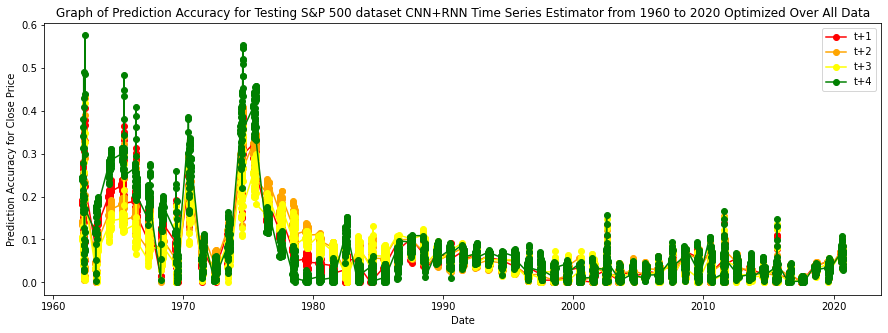

In [111]:
plt.figure(figsize=(15, 5));
plt.plot(date_test_rnn_opt, error_test_rnn_1_opt, color = 'red', label = 't+1', marker= 'o')
plt.plot(date_test_rnn_opt+ pd.Timedelta('1 day'), error_test_rnn_2_opt, color = 'orange', label = 't+2', marker= 'o')
plt.plot(date_test_rnn_opt+ pd.Timedelta('2 day'), error_test_rnn_3_opt, color = 'yellow', label = 't+3', marker= 'o')
plt.plot(date_test_rnn_opt+ pd.Timedelta('3 day'), error_test_rnn_4_opt, color = 'green', label = 't+4', marker= 'o')
plt.title('Graph of Prediction Accuracy for Testing S&P 500 dataset CNN+RNN Time Series Estimator from 1960 to 2020 Optimized Over All Data')
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Close Price')
plt.legend()
plt.show()

##### Show the graph separately.

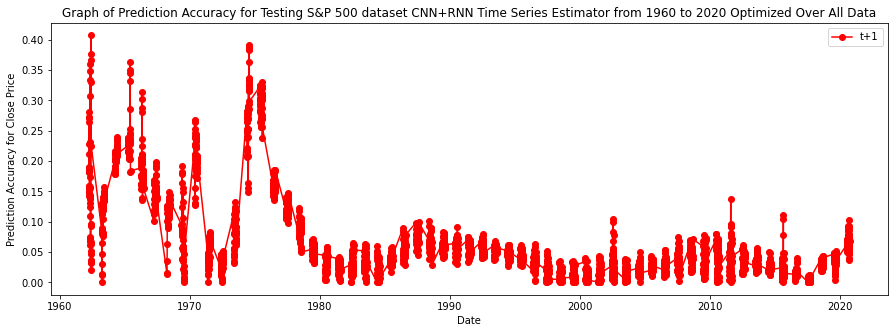

In [112]:
plt.figure(figsize=(15, 5));
plt.plot(date_test_rnn_opt, error_test_rnn_1_opt, color = 'red', label = 't+1', marker= 'o')
plt.title('Graph of Prediction Accuracy for Testing S&P 500 dataset CNN+RNN Time Series Estimator from 1960 to 2020 Optimized Over All Data')
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Close Price')
plt.legend()
plt.show()

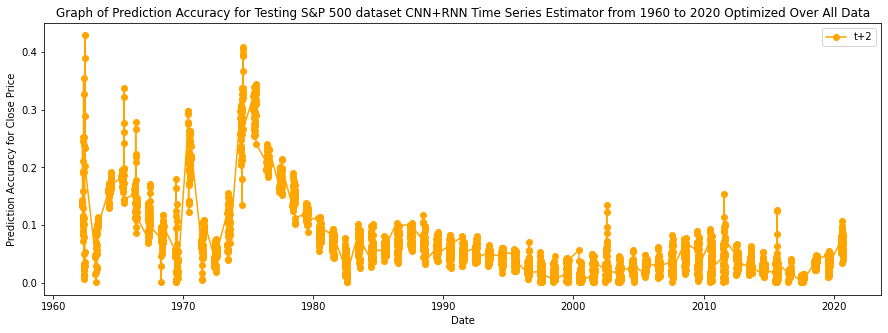

In [113]:
plt.figure(figsize=(15, 5));
plt.plot(date_test_rnn_opt+ pd.Timedelta('1 day'), error_test_rnn_2_opt, color = 'orange', label = 't+2', marker= 'o')
plt.title('Graph of Prediction Accuracy for Testing S&P 500 dataset CNN+RNN Time Series Estimator from 1960 to 2020 Optimized Over All Data')
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Close Price')
plt.legend()
plt.show()

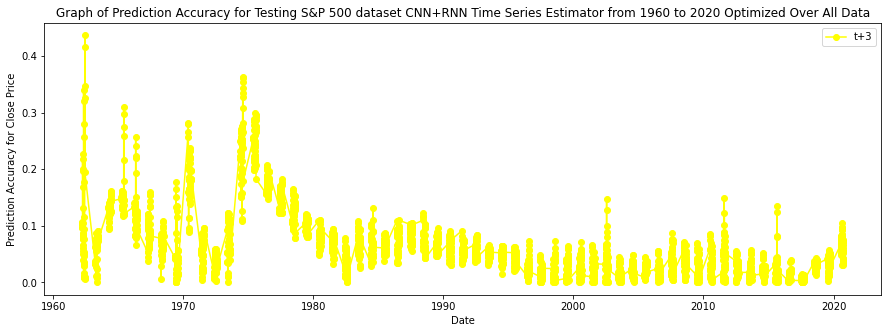

In [114]:
plt.figure(figsize=(15, 5));
plt.plot(date_test_rnn_opt+ pd.Timedelta('2 day'), error_test_rnn_3_opt, color = 'yellow', label = 't+3', marker= 'o')
plt.title('Graph of Prediction Accuracy for Testing S&P 500 dataset CNN+RNN Time Series Estimator from 1960 to 2020 Optimized Over All Data')
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Close Price')
plt.legend()
plt.show()

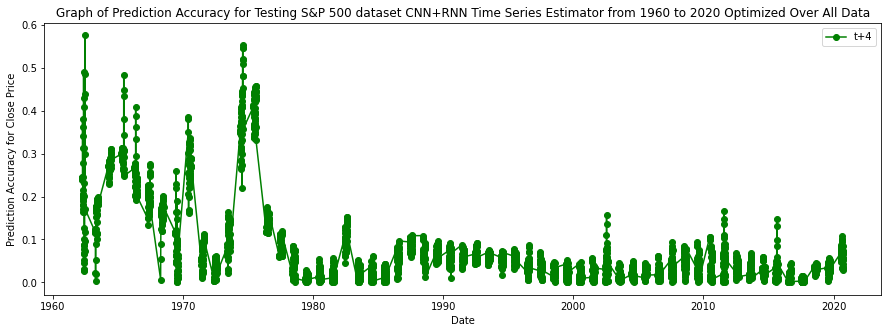

In [115]:
plt.figure(figsize=(15, 5));
plt.plot(date_test_rnn_opt+ pd.Timedelta('3 day'), error_test_rnn_4_opt, color = 'green', label = 't+4', marker= 'o')
plt.title('Graph of Prediction Accuracy for Testing S&P 500 dataset CNN+RNN Time Series Estimator from 1960 to 2020 Optimized Over All Data')
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Close Price')
plt.legend()
plt.show()

## Enhance CNN+RNN algorithm's functionality to generate a SELL signal when the S&P500 is about to peak, then use the algorithm developed above of this assignment to check the CNN+RNN algorithm.

In [116]:
x_opt.shape

(14991, 180, 3)

In [146]:
# assuming we have $1 million at the beginning
money = 1
money_end_opt = []
trade_end_opt = []
# we can not buy a new one until we sell the stock
last_trade_opt = 0
for i in range(nsample-1, x_opt.shape[0]):
    temp = sc.inverse_transform(x_opt[i,:, :])
    prob_temp = temp[:, 2]
    price_temp = temp[:, 0]
    if prob_temp[nsample-1] > 0.99 and (i-last_trade_opt > nsample):
        # sell the stock
        # re-buy at the local minimum in the next 180 days
        buy_price = min(price_temp)
        # in case of the overflow
        if buy_price > 0:
            sell_price = price_temp[len(price_temp)-1]
            money = (sell_price/buy_price*money)
            lastselltime = i
            money_end_opt.append(money)
            trade_end_opt.append(i)
print('The final money is: ', money)

The final money is:  1.5403486622096976e+176


Text(0, 0.5, 'Money (millions)')

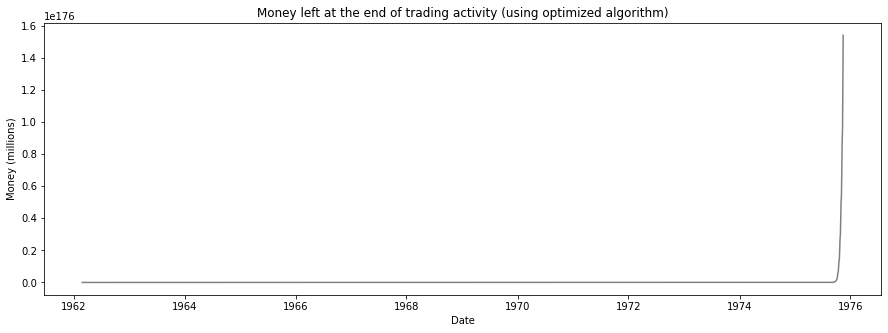

In [149]:
plt.figure(figsize=(15, 5));
plt.plot(date_full[trade_end_opt],
         money_end_opt, color='grey', label='Close')
plt.title('Money left at the end of trading activity (using optimized algorithm)')
plt.xlabel('Date')
plt.ylabel('Money (millions)')

## Determine the Effect of Input Data Perturbations (Price Uncertainty) on CNN+RNN Algorithm.

### Using Optimized CNN+RNN algorithm, add noise to the S&P 500 price data. Any negative values that result from noise corruption of S&P500 price data should be set to some small value greater than zero.

In [150]:
# standard deviation
sd = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
def NoiseData(dataset, sigma):
    dataset_noise = np.ndarray(shape = dataset.shape, dtype=np.float32)
    for i in range(len(dataset)):
        s = np.random.normal(0, sigma, 18)
        index = random.sample(list(range(window_size)), 18)
        dataset_noise[i] = dataset[i] 
        #scale the S accordingly within the sampling window
        s = max(x_test_rnn_opt[1, index, 0])*s
        temp = dataset_noise[i, index, 0] + s
        # modify the data if it is negative
        temp[temp < 0] = 0.0000001
        dataset_noise[i, index, 0]  = temp
        
    return dataset_noise   

### Repeat Tests, with noise-corrupted Test Set.

In [155]:
#predict next one day
out_temp = np.concatenate( (y_test_rnn_opt[:, :, 0], y_test_rnn_opt[:, :, 0], y_test_rnn_opt[:, :, 0]), axis = 1)
target_test = sc.inverse_transform(out_temp)[:, [0]]
error_res_all = []
for sigma in sd:
    dataset_test_noise = NoiseData(x_test_rnn_opt, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = rnn_opt(test_inputs)
    out_temp = np.concatenate((output_test.detach().numpy()[:, [0]], 
                               output_test.detach().numpy()[:, [0]],  
                               output_test.detach().numpy()[:, [0]]), axis=1)
    predicted_price_test = sc.inverse_transform(out_temp)[:, [0]]
    error = prediction_error(target_test, predicted_price_test)
    error_res_all.append(error.reshape(-1))

labels = date_test_rnn_opt[:,0]
error_df=pd.DataFrame(error_res_all, columns=labels, index=sd).T
error_df

,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
1962-03-26,0.222137,0.221696,0.221966,0.221704,0.221257,0.221743,0.221567,0.224551,0.221979
1962-03-27,0.222718,0.222708,0.222998,0.222725,0.222710,0.222802,0.222875,0.222750,0.203750
1962-03-28,0.233507,0.233531,0.233552,0.233372,0.233501,0.233657,0.234994,0.226868,0.233484
1962-03-29,0.235809,0.235911,0.235910,0.236482,0.235590,0.234721,0.236570,0.234826,0.232934
1962-03-30,0.229771,0.229768,0.229791,0.229777,0.229548,0.229771,0.229301,0.227000,0.229928
...,...,...,...,...,...,...,...,...,...
2020-09-21,0.049261,0.049261,0.049261,0.049261,0.049262,0.049257,0.049241,0.049261,0.049261
2020-09-22,0.065042,0.065045,0.065042,0.065043,0.065035,0.065042,0.065042,0.065042,0.065049
2020-09-23,0.042849,0.042849,0.042849,0.042849,0.042853,0.042876,0.042870,0.042849,0.042849
2020-09-24,0.051685,0.051689,0.051685,0.051685,0.051679,0.051723,0.051686,0.051685,0.051503


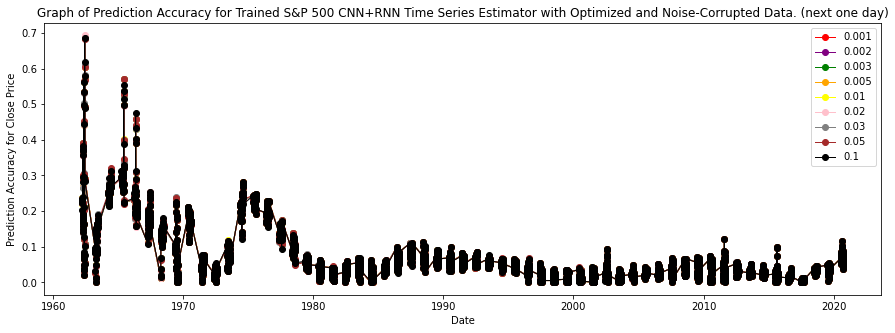

In [156]:
cmaps= ['red','purple', 'green', 'orange',  'yellow', 'pink', 'grey', 'brown', 'black','blue' ]
plt.figure(1, figsize=(15, 5))
for i in range(len(sd)):    
    plt.plot(date_test_rnn_opt, error_res_all[i], color=cmaps[i], lw=1, label = sd[i], marker= 'o')  
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Close Price')
plt.title('Graph of Prediction Accuracy for Trained S&P 500 CNN+RNN Time Series Estimator with Optimized and Noise-Corrupted Data. (next one day)')
plt.legend(loc="upper right") 

In [157]:
#predict next two days
out_temp = np.concatenate( (y_test_rnn_opt[:, :, 1], y_test_rnn_opt[:, :, 1], y_test_rnn_opt[:, :, 1]), axis = 1)
target_test = sc.inverse_transform(out_temp)[:, [0]]
error_res_all = []
for sigma in sd:
    dataset_test_noise = NoiseData(x_test_rnn_opt, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = rnn_opt(test_inputs)
    out_temp = np.concatenate((output_test.detach().numpy()[:, [1]], 
                               output_test.detach().numpy()[:, [1]],  
                               output_test.detach().numpy()[:, [1]]), axis=1)
    predicted_price_test = sc.inverse_transform(out_temp)[:, [0]]
    error = prediction_error(target_test, predicted_price_test)
    error_res_all.append(error.reshape(-1))

labels = date_test_rnn_opt[:,0]
error_df=pd.DataFrame(error_res_all, columns=labels, index=sd).T
error_df

,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
1962-03-26,0.154590,0.154555,0.154547,0.154555,0.154344,0.154547,0.158762,0.157921,0.154555
1962-03-27,0.163807,0.163662,0.163717,0.163720,0.163683,0.163717,0.161642,0.163687,0.163492
1962-03-28,0.167612,0.167864,0.167630,0.167601,0.167832,0.167625,0.167262,0.165320,0.166646
1962-03-29,0.163340,0.163331,0.163496,0.163312,0.163322,0.161532,0.163368,0.163370,0.175227
1962-03-30,0.161937,0.161810,0.161750,0.161928,0.161931,0.161877,0.165199,0.161879,0.162369
...,...,...,...,...,...,...,...,...,...
2020-09-21,0.061436,0.061437,0.061434,0.061436,0.061448,0.061437,0.061436,0.061436,0.061364
2020-09-22,0.041154,0.041155,0.041154,0.041164,0.041154,0.041152,0.041155,0.041180,0.041154
2020-09-23,0.047918,0.047918,0.047918,0.047910,0.047918,0.047918,0.047918,0.047918,0.047919
2020-09-24,0.070118,0.070119,0.070119,0.070118,0.070119,0.070159,0.070121,0.070198,0.070133


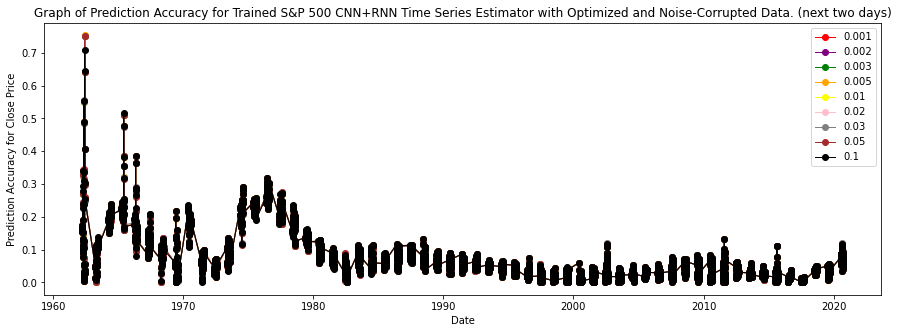

In [158]:
cmaps= ['red','purple', 'green', 'orange',  'yellow', 'pink', 'grey', 'brown', 'black','blue' ]
plt.figure(1, figsize=(15, 5))
for i in range(len(sd)):    
    plt.plot(date_test_rnn_opt+ pd.Timedelta('1 day'), error_res_all[i], color=cmaps[i], lw=1, label = sd[i], marker= 'o')  
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Close Price')
plt.title('Graph of Prediction Accuracy for Trained S&P 500 CNN+RNN Time Series Estimator with Optimized and Noise-Corrupted Data. (next two days)')
plt.legend(loc="upper right") 

In [159]:
#predict next three days
out_temp = np.concatenate( (y_test_rnn_opt[:, :, 2], y_test_rnn_opt[:, :, 2], y_test_rnn_opt[:, :, 2]), axis = 1)
target_test = sc.inverse_transform(out_temp)[:, [0]]
error_res_all = []
for sigma in sd:
    dataset_test_noise = NoiseData(x_test_rnn_opt, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = rnn_opt(test_inputs)
    out_temp = np.concatenate((output_test.detach().numpy()[:, [2]], 
                               output_test.detach().numpy()[:, [2]],  
                               output_test.detach().numpy()[:, [2]]), axis=1)
    predicted_price_test = sc.inverse_transform(out_temp)[:, [0]]
    error = prediction_error(target_test, predicted_price_test)
    error_res_all.append(error.reshape(-1))

labels = date_test_rnn_opt[:,0]
error_df=pd.DataFrame(error_res_all, columns=labels, index=sd).T
error_df

,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
1962-03-26,0.116923,0.116993,0.117046,0.116993,0.116949,0.116940,0.118112,0.116993,0.112325
1962-03-27,0.119513,0.119806,0.119250,0.119541,0.119543,0.119543,0.119538,0.119577,0.125993
1962-03-28,0.115948,0.116050,0.116097,0.116082,0.115777,0.114837,0.116031,0.115839,0.116033
1962-03-29,0.116096,0.116072,0.116067,0.116086,0.116077,0.116054,0.116939,0.116070,0.115275
1962-03-30,0.108794,0.108826,0.108859,0.108650,0.108843,0.108386,0.107801,0.108875,0.108543
...,...,...,...,...,...,...,...,...,...
2020-09-21,0.031502,0.031504,0.031504,0.031504,0.031504,0.031462,0.031504,0.031462,0.031460
2020-09-22,0.038770,0.038770,0.038770,0.038770,0.038770,0.038775,0.038752,0.038771,0.038773
2020-09-23,0.059236,0.059236,0.059236,0.059235,0.059243,0.059236,0.059236,0.059236,0.059174
2020-09-24,0.081513,0.081514,0.081514,0.081514,0.081513,0.081516,0.081488,0.081514,0.081568


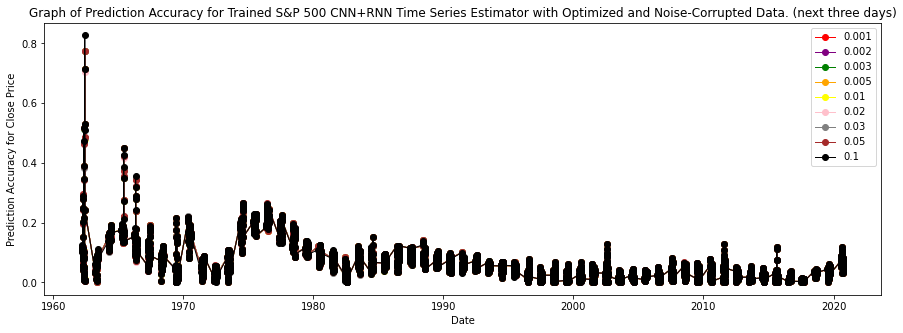

In [160]:
cmaps= ['red','purple', 'green', 'orange',  'yellow', 'pink', 'grey', 'brown', 'black','blue' ]
plt.figure(1, figsize=(15, 5))
for i in range(len(sd)):    
    plt.plot(date_test_rnn_opt+ pd.Timedelta('2 day'), error_res_all[i], color=cmaps[i], lw=1, label = sd[i], marker= 'o')  
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Close Price')
plt.title('Graph of Prediction Accuracy for Trained S&P 500 CNN+RNN Time Series Estimator with Optimized and Noise-Corrupted Data. (next three days)')
plt.legend(loc="upper right") 

In [161]:
#predict next four days
out_temp = np.concatenate( (y_test_rnn_opt[:, :, 3], y_test_rnn_opt[:, :, 3], y_test_rnn_opt[:, :, 3]), axis = 1)
target_test = sc.inverse_transform(out_temp)[:, [0]]
error_res_all = []
for sigma in sd:
    dataset_test_noise = NoiseData(x_test_rnn_opt, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = rnn_opt(test_inputs)
    out_temp = np.concatenate((output_test.detach().numpy()[:, [3]], 
                               output_test.detach().numpy()[:, [3]],  
                               output_test.detach().numpy()[:, [3]]), axis=1)
    predicted_price_test = sc.inverse_transform(out_temp)[:, [0]]
    error = prediction_error(target_test, predicted_price_test)
    error_res_all.append(error.reshape(-1))

labels = date_test_rnn_opt[:,0]
error_df=pd.DataFrame(error_res_all, columns=labels, index=sd).T
error_df

,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
1962-03-26,0.323813,0.323813,0.324097,0.323611,0.323668,0.323808,0.323567,0.313179,0.335708
1962-03-27,0.320395,0.320135,0.320116,0.320136,0.318382,0.322708,0.320127,0.320133,0.325297
1962-03-28,0.322456,0.322251,0.322472,0.322658,0.324842,0.320204,0.322455,0.325582,0.322299
1962-03-29,0.315688,0.315690,0.315692,0.316088,0.315691,0.320505,0.315690,0.318852,0.315747
1962-03-30,0.311713,0.311489,0.311570,0.311559,0.312825,0.311385,0.311368,0.311590,0.311323
...,...,...,...,...,...,...,...,...,...
2020-09-21,0.035804,0.035806,0.035806,0.035807,0.035813,0.035806,0.035805,0.035820,0.035786
2020-09-22,0.057326,0.057326,0.057319,0.057326,0.057326,0.057334,0.057326,0.057368,0.057325
2020-09-23,0.077678,0.077680,0.077680,0.077680,0.077680,0.077676,0.077681,0.077680,0.077680
2020-09-24,0.078424,0.078424,0.078418,0.078424,0.078418,0.078413,0.078424,0.078424,0.078195


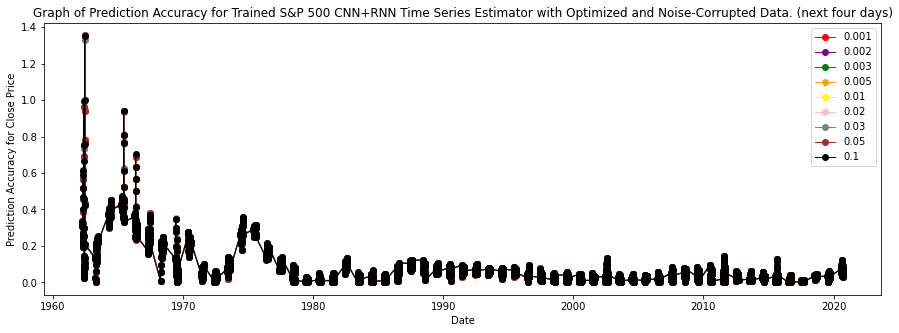

In [162]:
cmaps= ['red','purple', 'green', 'orange',  'yellow', 'pink', 'grey', 'brown', 'black','blue' ]
plt.figure(1, figsize=(15, 5))
for i in range(len(sd)):    
    plt.plot(date_test_rnn_opt+ pd.Timedelta('3 day'), error_res_all[i], color=cmaps[i], lw=1, label = sd[i], marker= 'o')  
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Close Price')
plt.title('Graph of Prediction Accuracy for Trained S&P 500 CNN+RNN Time Series Estimator with Optimized and Noise-Corrupted Data. (next four days)')
plt.legend(loc="upper right") 

###  Determine how much money will make or lose when the input is perturbed.

#### Construct images of the test dataset.

In [191]:
img_test = []
for i in range(x_test_rnn_opt.shape[0]):
    x = x_test_rnn_opt[i, :, 0]
    # show the S&P 500 data
    plt.axis('off')
    plt.plot(x, color='black', lw=1)
    figure = plt.gcf() # get current figure
    figure.set_size_inches(8, 8)
    figure.canvas.draw()

    width, height = figure.get_size_inches() * figure.get_dpi()
    mplimage = np.frombuffer(figure.canvas.tostring_rgb(), dtype='uint8').reshape(576, 576, 3)
    gray_image = color.rgb2gray(mplimage)
    img_resize = resize(gray_image, (200, 200),anti_aliasing=True)
    img_resize = img_resize.astype('float32')
    plt.clf()   
    # appending the image into the list
    img_test.append(img_resize)

# transfer the list to numpy array
test_x = np.array(img_test)

<Figure size 576x576 with 0 Axes>

In [192]:
# transfer the numpy array to tensor
test_x = test_x.reshape(test_x.shape[0], 1, test_x.shape[1], test_x.shape[2])
test_x = torch.from_numpy(test_x)

#### Generate sell signal for all dataset.

In [193]:
with torch.no_grad():
    output_final = model(test_x)

softmax = torch.exp(output_final)
prob_final = softmax.numpy()[:,1]/np.sum(softmax.numpy(), axis=1)

#### Show how much will left with the noise interruption.

In [197]:
money_left_all = []
trade_left_all = []
std = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
for sigma in std:
    dataset_test_noise_final = NoiseData(x_test_rnn_opt, sigma)
    img_test = []
    for i in range(dataset_test_noise_final.shape[0]):
        if i%500 == 0:
            print(i)
        x = dataset_test_noise_final[i,:,0]
        # show the S&P 500 data
        plt.axis('off')
        plt.plot(x, color='black', lw=1)
        figure = plt.gcf() # get current figure
        figure.set_size_inches(8, 8)
        figure.canvas.draw()

        width, height = figure.get_size_inches() * figure.get_dpi()
        mplimage = np.frombuffer(figure.canvas.tostring_rgb(), dtype='uint8').reshape(576, 576, 3)
        gray_image = color.rgb2gray(mplimage)
        img_resize = resize(gray_image, (200, 200),anti_aliasing=True)
        img_resize = img_resize.astype('float32')
        plt.clf()
        # appending the image into the list
        img_test.append(img_resize)

    # transfer the list to numpy array
    test_x = np.array(img_test)

    # transfer the numpy array to tensor
    test_x = test_x.reshape(test_x.shape[0], 1, test_x.shape[1], test_x.shape[2])
    test_x = torch.from_numpy(test_x)

    # predict the sell signal for all data
    with torch.no_grad():
        output_final = model(test_x)
    
    softmax = torch.exp(output_final)
    prob_final = softmax.numpy()[:,1]/np.sum(softmax.numpy(), axis=1)

    # calculate the money left
    # we have 1 million at the beginning
    money = 1
    money_full = []
    trade_full = []
    last_sell = 0
    for i in range(1,x_test_rnn_opt.shape[0]):
        temp = sc.inverse_transform(x_test_rnn_opt[i,:,:])
        prob_temp = prob_final[i]
        price_temp = temp[:,0]
        date_diff = date_test_rnn_opt[i,0] - date_test_rnn_opt[last_sell,0]
        days = date_diff.astype('timedelta64[D]')
        days_diff = days/np.timedelta64(1, 'D')
        if prob_temp > 0.97 and (days_diff > nsample):
            # sell and buy at the local minimum
            buy_price = min(price_temp)
            # avoid overflow
            if buy_price > 0:
                sell_price = price_temp[len(price_temp)-1]
                money = sell_price/buy_price*money
                last_sell = i
                print(money)
                print(i)
                money_full.append(money)
                trade_full.append(i)

    money_left_all.append(money_full)
    trade_left_all.append(trade_full)

0
500
1000
1500
2000
2500
3000
1.2413535149989339
53
1.4468440801468918
106
1.5336689051663777
159
1.6238417067941027
212
1.9796671667434946
265
2.1094333099150515
318
2.31070597710607
371
2.3572630563739527
424
2.932091793169794
477
3.475192081293785
530
3.475192081293785
583
3.475192081293785
636
5.025859919524584
689
6.194622139553977
742
0
500
1000
1500
2000
2500
3000
1.2413535149989339
53
1.4468440801468918
106
1.5336689051663777
159
1.6238417067941027
212
1.9796671667434946
265
2.1094333099150515
318
2.31070597710607
371
2.3572630563739527
424
2.932091793169794
477
3.475192081293785
530
3.475192081293785
583
3.475192081293785
636
5.025859919524584
689
6.194622139553977
742
0
500
1000
1500
2000
2500
3000
1.2413535149989339
53
1.4468440801468918
106
1.5336689051663777
159
1.6238417067941027
212
1.9796671667434946
265
2.1094333099150515
318
2.31070597710607
371
2.3572630563739527
424
2.932091793169794
477
3.475192081293785
530
3.475192081293785
583
3.475192081293785
636
5.0258599195

<Figure size 576x576 with 0 Axes>

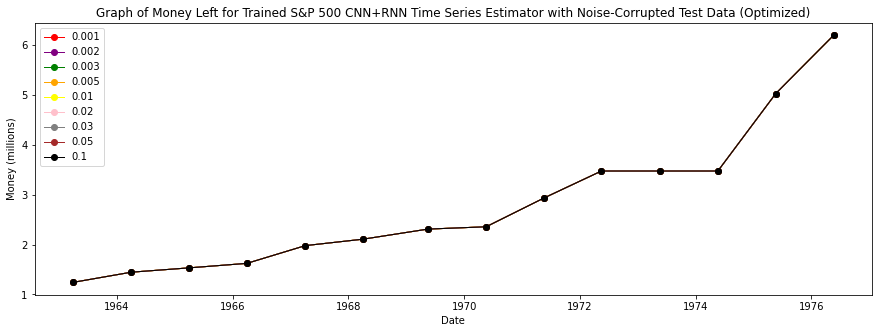

In [198]:
cmaps= ['red','purple', 'green', 'orange',  'yellow', 'pink', 'grey', 'brown', 'black','blue' ]
plt.figure(1, figsize=(15, 5))
for i in range(len(std)):   
    plt.plot(date_test_rnn_opt[trade_left_all[i]], money_left_all[i] , color=cmaps[i], lw=1, label = sd[i], marker= 'o')  
plt.xlabel('Date')
plt.ylabel('Money (millions)')
plt.title('Graph of Money Left for Trained S&P 500 CNN+RNN Time Series Estimator with Noise-Corrupted Test Data (Optimized)')
plt.legend(loc="upper left") 

In [199]:
print(money_left_all[0][-1])
print(money_left_all[1][-1])
print(money_left_all[2][-1])
print(money_left_all[3][-1])
print(money_left_all[4][-1])
print(money_left_all[5][-1])
print(money_left_all[6][-1])
print(money_left_all[7][-1])
print(money_left_all[8][-1])

6.194622139553977
6.194622139553977
6.194622139553977
6.194622139553977
6.194622139553977
6.194622139553977
6.194622139553977
6.194622139553977
6.194622139553977
